# Практикум по стохастическому анализу. Часть №1

Выполнил \
Пилюшенок Артур \
студент 415 группы ВМК МГУ

In [1]:
import numpy as np                              # matrix calculations
from matplotlib import pyplot as plt            # plotting
from time import time                           # time of calculations

# empirical cumulative distribution function, distributions and quantiles
from scipy.stats import ecdf, norm, poisson, t, f, probplot, chi2

# for integral
from itertools import combinations_with_replacement
from scipy.special import factorial

Префиксы
- $\texttt{rand}$ - датчики (генераторы) распределений
- $\texttt{gen}$ - датчики (генераторы) распределений, производных от датчиков $\texttt{rand}$, или генераторы траекторий
- $\texttt{test}$ - реализация критериев для проверки гипотез

## Задание 1

### Условие
1. Реализовать генератор схемы Бернулли с заданной вероятностью успеха $p$. На
основе генератора схемы Бернулли построить датчик биномиального распределения.

2. Реализовать генератор геометрического распределения; проверить для данного
распределения свойство отсутствия памяти.

3. Промоделировать игру в орлянку: бесконечную последовательность независимых испытаний Бернулли 
с бросанием “правильной” (честной, $p=0.5$) монеты. Величина “выигрыша” $S_n$ определяется как сумма 
по $n$ испытаниям значений 1 и −1 в зависимости от выпавшей стороны монеты. Проиллюстрировать в виде
ломаной поведение нормированной суммы $Y(i)=\frac{S_i}{\sqrt{n}}$ как функцию от номера испытания $i$ 
для отдельно взятой траектории. Дать теоретическую оценку для значения $Y(n)$ при $n\to\infty$.

### Генераторы схемы Бернулли и биномиального распределения

Воспользуемся методом обращения функции распределения. Он основан на следующем утверждении.

__Утвержденине__ Пусть функция распределения $F(\cdot)$ имеет обратную $F^{-1}(\cdot)$. Положим $\nu\sim\mathrm{U}[0,1]$. Тогда функцией распределения случайной величины $\xi=F^{-1}(\nu)$ является $F(\cdot)$.

Доказательство.
$$
F_\xi(x) = \mathbb{P}(\xi < x) = \mathbb{P}(F^{-1}(\nu) < x) = \mathbb{P}(\nu < F(x)) = F(x).
$$

Мы будем использовать генератор многомерной выборки, отвечающей схеме Бернулли, реализованный при помощи метода $\texttt{numpy.random.rand}$. \
Это позволит нам генерировать несколько двумерных выборок одновременно.

In [2]:
def rand_bern(p, *args):
    '''
    Bernoulli scheme generator
    returns tensor with given shapes
    p - probability of success, must be in the range [0,1]
    args consists of positive integer numbers (resulting dimensions)
    dimension error handling in np.random.rand
    '''
    if p > 1 or p < 0:
        raise ValueError("Probability of success must be in range [0,1].")
    if not args:
        return int(np.random.rand() < p)
    return (np.random.rand(*args) < p).astype(int)

В качестве примера работы генератора схемы Бернулли изобразим гистограмму для выборки размера $N = 10^7$. \
Вероятность единицы должна быть близка к параметру $p$ генератора.

In [3]:
p = 0.54321
N = 10**7
sample_bern = rand_bern(p, N)

Parameter p=0.54321.
Probability of 1 at sample: 0.54331.


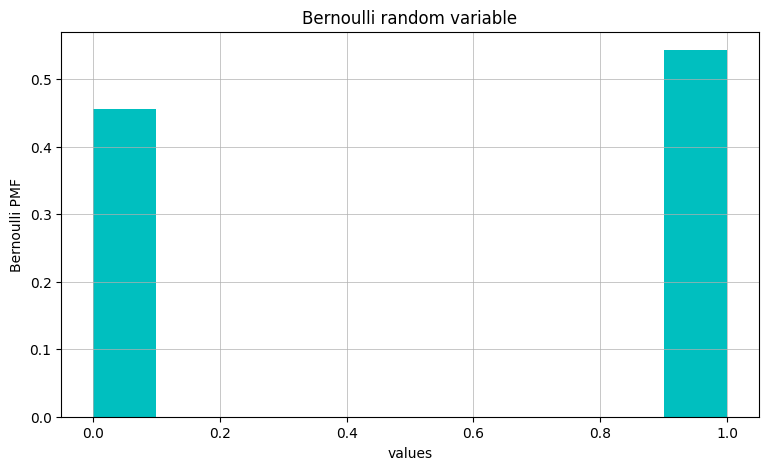

In [4]:
fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

counts, bins = np.histogram(sample_bern)
ax.stairs(counts / N, bins, fill=True, color='c')
print('Parameter p={:1.5f}.\nProbability of 1 at sample: {:1.5f}.'.format(p, counts[-1] / N))

ax.set_title('Bernoulli random variable')
ax.set_ylabel('Bernoulli PMF')
ax.set_xlabel('values')
plt.show()

Далее воспользуемся $\texttt{rand\_bern}$ для реализации генератора $\mathrm{Bin}(n,p)$.

Здесь можно сгенерировать одним запуском $n$ выборок схемы Бернулли, но при больших $n$ память легко может переполниться. \
Например, двумерная выборка размерности $100$ на $100$ при $n=10^7$ переполняет свободную память компьютера, хотя и состоит всего из $10^5$ значений.

Чтобы избежать переполнения памяти при больших $n$, можно запускать $\texttt{rand\_bin}$ в цикле.

In [5]:
def rand_bin(n, p, *args):
    '''
    Binomial distribution generator
    returns tensor with given shapes
    n - count of trials, is positive integer number
    p - probability of success, must be in the range [0,1]
    args consists of positive integer numbers (resulting dimensions)
    error handling in rand_bern
    '''
    if not isinstance(n, (int, np.integer)) or not n > 0:
        raise ValueError("Count of trials must be a positive integer.")
    return rand_bern(p, n, *args).sum(axis=0)

Отметим, что генерация одним запуском в разы эффективнее генерации в цикле.
<!-- Приведем листинг эффективной по времени генерации, но приводящей к переполнению.
```python
def rand_bin(n, p, *args):
    if not isinstance(n, int) or not n > 0:
        raise ValueError("Count of trials must be a positive integer.")
    return rand_bern(p, n, *args).sum(axis=0)
``` -->
Данной реализацией можно пользоваться при произведении $n$ на все результирующие размерности меньшем $10^8$ (или меньшем количества свободных байт в памяти компьютера). Для генерации выборок большого размера будем последовательно вызывать генератор.

Продемонстрируем работу датчика биномиального распределения: проверим выполнение ЦПТ (биномиальная случайная величина является суммой бернуллевских случайных величин).

In [6]:
n = 66
p = 0.54321
N = 10**6

sample_bin = rand_bin(n, p, N)

mu = n*p
sigma = np.sqrt(n*p*(1-p))
print('Teoretical mu={:1.4}, sigma={:1.4}'.format(mu, sigma))
print('Numerical mu={:1.4}, sigma={:1.4}'.format(sample_bin.mean(), sample_bin.std()))

Teoretical mu=35.85, sigma=4.047
Numerical mu=35.85, sigma=4.046


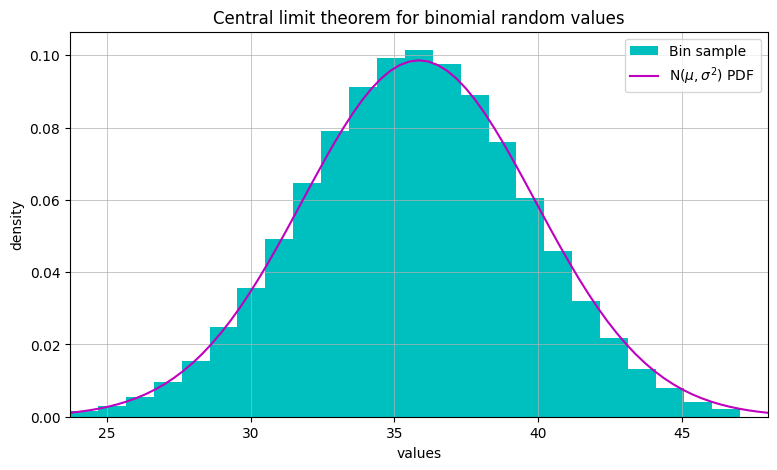

In [7]:
n_bins = 25
grid = np.linspace(mu - 3*sigma, mu + 3*sigma, n_bins*3)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)
ax.set_xlim([mu - 3*sigma, mu + 3*sigma])

ax.hist(sample_bin, bins=n_bins, range=(mu - 3*sigma, mu + 3*sigma), color='c', density=True, label='Bin sample')
ax.plot(grid, norm.pdf(grid, loc=mu, scale=sigma), color='m', label='N($\mu,\sigma^2$) PDF')

plt.title('Central limit theorem for binomial random values')
plt.ylabel('density')
plt.xlabel('values')
plt.legend()
plt.show()

### Генератор геометрического распределения


Всюду далее считаем, что геометрическое распределение - это распределение числа неуспехов до первого успеха 
в схеме Бернулли с неограниченным числом испытаний.

Обозначим
$$
\xi \sim \operatorname{Geom}(p),\quad \nu \sim \operatorname{U}[0,1].\\
\mathbb{P}(\xi = n) = p(1-p)^n,\quad \sum_{k=0}^{n} p(1-p)^k = 1 - (1-p)^{n+1} = s_{n+1}.
$$
Пользуясь генератором равномерного распределения, реализуем генератор геометрического распределения, исходя из следующих соображений:
$$
\mathbb{P}(\xi = n) = \mathbb{P}(s_{n}<\nu\leqslant s_{n+1}) = \mathbb{P}((1-p)^{n+1} \leqslant 1-\nu < (1-p)^{n}).
$$
$$
\Longrightarrow~ \boxed{\mathbb{P}(\xi = n) = \mathbb{P}\left( n < \dfrac{\ln{(1-\nu)}}{\ln(1-p)} \leqslant n+1  \right).}
$$
Отметим, что $(1-\nu) \sim \operatorname{U}[0,1]$.

Таким образом, будем моделировать случайную величину
$$
\eta = \bigg\lfloor \dfrac{\ln\nu}{\ln(1-p)} \bigg\rfloor.
$$

Можно доказать, что $\frac{\ln\nu}{\ln(1-p)}\sim\mathrm{Exp}(\ln\frac{1}{1-p})$:
$$
\mathbb{P}\left(\frac{\ln\nu}{\ln(1-p)}<x\right) = \mathbb{P}(\nu < e^{\ln(1-p)x}) = 1 - e^{\ln(1-p)x}.
$$

In [8]:
def rand_geom(p, *args):
    '''
    Geometrical distribution generator
    returns tensor with given shapes
    p - probability of success, must be in range [0,1]
    args consists of positive integer numbers (resulting dimensions)
    dimension error handling in np.random.rand
    '''
    if p > 1 or p < 0:
        raise ValueError("Probability of success must be in range [0,1].")
    return np.floor(np.log(np.random.rand(*args)) / np.log(1-p)).astype(int)

Покажем, что данное распределение обладает свойством отсутствия памяти:
$$
\mathbb{P}(\xi > m+n ~\vert~ \xi \geqslant m) = \mathbb{P}(\xi > n),~ \forall m,n \in \{0,1,2\dots\}
$$

Для этого построим две гистограммы для двух выборок (отвечающих левой и правой частям соответственно). \
Сдвинутые графики должны совпасть.

In [9]:
p = 0.2
N = 10**7
m = 7

In [10]:
sample_geom_1 = rand_geom(p, N)
sample_geom_2 = rand_geom(p, N)
sample_geom_2 = sample_geom_2[sample_geom_2 >= m]
sample_geom_2.shape

(2097434,)

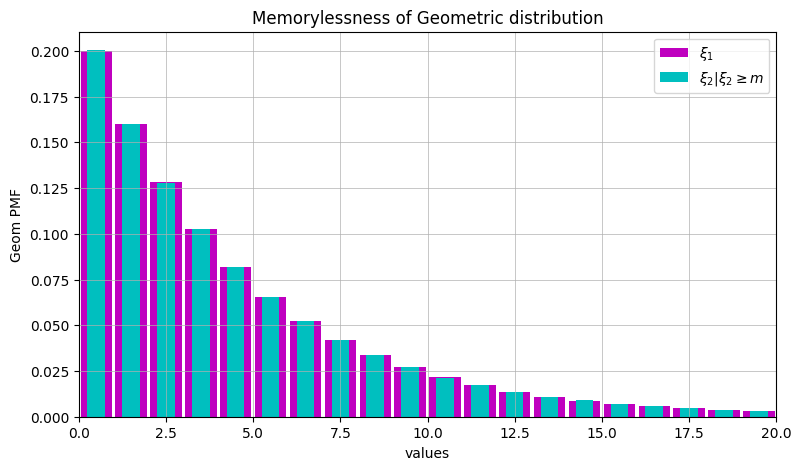

In [11]:
n_bins = 30
bins = np.arange(0, n_bins)

alpha = 0.01
xlim = np.floor(np.log(alpha) / np.log(1-p))

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)
ax.set_xlim([0, xlim])

ax.hist(sample_geom_1, bins,
    density=True,
    rwidth=0.9,
    color='m',
    label='$\\xi_1$'
)
ax.hist(sample_geom_2 - m, bins,
    density=True,
    rwidth=0.5,
    color='c',
    label='$\\xi_2|\\xi_2\\geq m$'
)

plt.title('Memorylessness of Geometric distribution')
plt.ylabel('Geom PMF')
plt.xlabel('values')
plt.legend()
plt.show()

### Игра в орлянку

Рассмотрим
$$
S_n = \sum^{n}_{i=1} \eta_i,\quad \eta_i = 2\xi_i-1,\quad \xi_i \sim \operatorname{Be}(p) \text{ --- i.i.d.r.v.}\\
Y_n = \dfrac{S_n}{\sqrt{n}}.
$$

Зафиксируем $p=1/2$. В таком случае
$$
\mathbb{E}\nu_i \equiv \mu = 2p-1 = 0.\\
\mathbb{D}\nu_i \equiv \sigma^2 = 4p(1-p) = 1.
$$

Воспользуемся ЦПТ.
$$
\mathbb{P}\left( \dfrac{S_n - n\mu}{\sigma\sqrt{n}} < x \right) \to \Phi(x)=\dfrac{1}{\sqrt{2\pi}}\int_{-\infty}^{x}e^{-y^2/2}dy,~n\to\infty.
$$

Заметим, что нормированная случайная величина внутри функции распределения в левой части выражения совпадает с $Y_n$. \
Также отметим, что третий абсолютный момент $\mathbb{E}|\eta_i|^3=1$, ведь $|\eta_i|\equiv1$. \
В таком случае можем воспользоваться неравенством Берри-Эссеена, где $c_0\in(0.4,0.5)$.
$$
\sup_{x\in\mathbb{R}}\left| \mathbb{P}\left( \dfrac{S_n}{\sqrt{n}} < x \right) - \Phi(x) \right| < \dfrac{c_0}{n^{3/2}}.
$$

Получили оценку скорости сходимости в ЦПТ. \
Нас также интересует оценка значений $Y_n(\omega)$.

Уже показали, что
$$
Y_n \stackrel{d}{\to} \xi\sim\mathrm{N}(0,1).
$$
Следовательно, по мере увеличения числа элементов $n$ нормированная сумма $Y(n)$ будет распределена нормально.

Также продемонстрируем поведение траектории $Y_i = \frac{S_i}{\sqrt{n}},~ i=\overline{0,n}$.

In [12]:
def gen_orlyanka_trajectory(p, n):
    '''
    Orlyanka game trajectory generator
    returns trajectory of normalized summ Y_n in orlyanka game
    n - count of trials, is positive integer number
    p - probability of success, must be in the range [0,1]
    args consists of positive integer numbers (resulting dimensions)
    error handling in rand_bern
    '''
    if not isinstance(n, (int, np.integer)) or not n > 0:
        raise ValueError("Count of trials must be a positive integer.")
    return np.append(0, (2 * rand_bern(p, n) - 1).cumsum() / np.sqrt(n))

def gen_orlyanka_value(p, n, *args):
    '''
    Orlyanka game generator
    returns tensor with given shapes
    n - count of trials, is positive integer number
    p - probability of success, must be in the range [0,1]
    args consists of positive integer numbers (resulting dimensions)
    error handling in rand_bern
    '''
    if not isinstance(n, (int, np.integer)) or not n > 0:
        raise ValueError("Count of trials must be a positive integer.")
    return (2 * rand_bern(p, n, *args) - 1).sum(axis=0) / np.sqrt(n)

In [13]:
p = 0.5
n = 1000
N = 10000

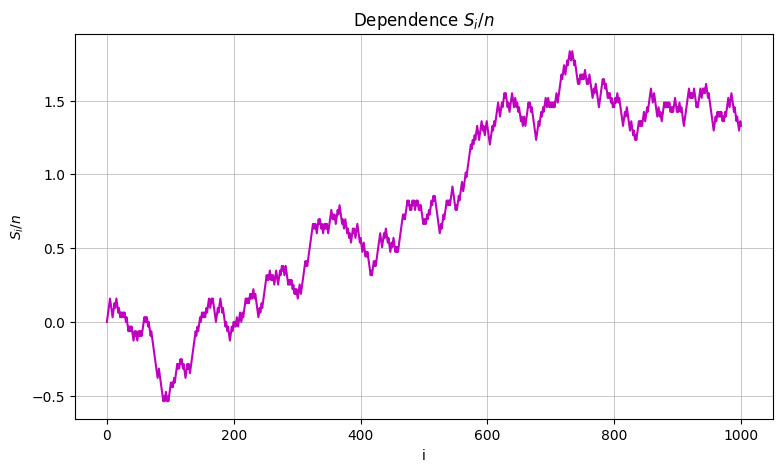

In [14]:
x = np.arange(0, n+1)
y = gen_orlyanka_trajectory(p, n)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.plot(x, y, color='m')

plt.title('Dependence $S_i/n$')
plt.xlabel('i')
plt.ylabel('$S_i/n$')
plt.show()

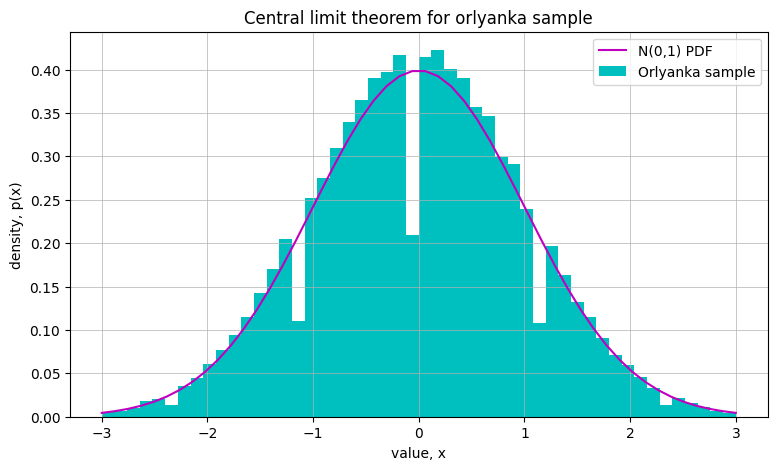

In [15]:
sample_orlyanka = gen_orlyanka_value(p, n, 10*N)

n_bins = 50
grid = np.linspace(-3, 3)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.hist(sample_orlyanka, bins=n_bins, range=(-3,3), density=True, color='c')
ax.plot(grid, norm.pdf(grid, loc=0.0, scale=1.0), color='m')

plt.title('Central limit theorem for orlyanka sample')
plt.xlabel('value, x')
plt.ylabel('density, p(x)')
plt.legend(['N(0,1) PDF', 'Orlyanka sample'])
plt.show()

## Задание 2

### Условие

1. Построить датчик сингулярного распределения, имеющий в качестве функции распределения канторову лестницу. 
С помощью критерия Колмогорова убедиться в корректности работы датчика.

2.  Для канторовых случайных величин с помощью критерия Смирнова проверить
свойство симметричности относительно $\frac{1}{2}$ ($X$ и $1 − X$ распределены одинаково)
и свойство самоподобия относительно деления на $3$ (условное распределение $Y$
при условии $Y ∈ [0, 1/3]$ совпадает с распределением $\frac{Y}{3}$).

3. Рассчитать значения математического ожидания и дисперсии для данного распределения. Сравнить теоретические значения с эмпирическими (для различных объемов выборок), проиллюстрировать сходимость эмпирических значений
к теоретическим.

### Генератор канторового распределения

Канторовская лестница задаётся на множестве Кантора (которое имеет нулевую меру Лебега) отрезка $[0,1]$, доопределяется по непрерывности в оставшихся точках. Канторовское распределение имеет функцию распределения, являющейся канторовской лестницей.

Есть два способа моделирования такого распределения:
1. По заданному $x\in[0,1]$. Канторовское множество состоит из тех точек, у которых нет единицы в троичной записи. Переведем $x$ в троичную запись, а затем отбросим все цифры после первой (самой левой) единицы.
2. По заданному размеру выборки $N$. Будем $N$ раз моделировать $n_{\operatorname{bits}}$ испытаний схемы Бернулли с $p=\frac{1}{2}$. Все единицы заменим на двойки, и получим троичную запись числа, в которой отсутствуют единицы.

Значением функции распределения $F(x)$ будет являться двоичное представление числа $x$. Его можно получить, заменив все двойки в троичной записи даного числа на единицы.

Число испытаний схемы Бернулли $n=n_{\operatorname{bits}}$ можно задавать с учётом заданной погрешности $\varepsilon$. В худшем случае отбрасываются двойки в троичной записи числа.
$$
\sum_{k=n+1}^{\infty} \dfrac{2^{k}}{3^{k}} = \dfrac{(\frac{2}{3})^{n+1}}{1 - \frac{2}{3}} < \varepsilon.
\quad\Rightarrow\quad
n + 1 < \log_{\frac{2}{3}}3\varepsilon.
$$

Будем генерировать канторовское распределение по заданному размеру выборки $N$ и точности $\varepsilon$.

In [16]:
def rand_Cantor(N, eps):
    '''
    Cantor distribution with use of Bernoulli scheme
    returns (x, y) where x,y \in [0,1], y corresponds to cumulative distribution function (CDF)
    N - count of points, is positive integer number
    eps - precision, is positive float number
    additional error handling in rand_bern
    '''
    if not isinstance(N, (int, np.integer)) or N <= 0:
        raise ValueError("Count of points must be a positive integer.")
    if not eps > 0:
        raise ValueError("Presicion must be positive.")
    p = 0.5
    n_bits = np.floor(np.log(3*eps)/np.log(2/3) - 1).astype(int)
    sample = np.empty(N)
    cdf = np.empty(N)
    for i in range(N):
        # get binary representation of float number after point
        X = rand_bern(p, n_bits)
        curr_point = 0
        curr_value = 0
        for j in range(1, n_bits+1):
            # change representation
            curr_point += 2 * X[j-1] / 3**j       # from 3 to 10
            curr_value += X[j-1] / 2**j           # from 2 to 10
        sample[i] = curr_point
        cdf[i] = curr_value
    return np.sort(sample), np.sort(cdf)

In [17]:
N = 10**5
eps = 1e-12
n_bits = np.floor(np.log(3*eps)/np.log(2/3) - 1).astype(int)
print(n_bits)

64


In [18]:
sample_Cantor, cdf_Cantor = rand_Cantor(N, eps)
ecdf_Cantor = ecdf(sample_Cantor)

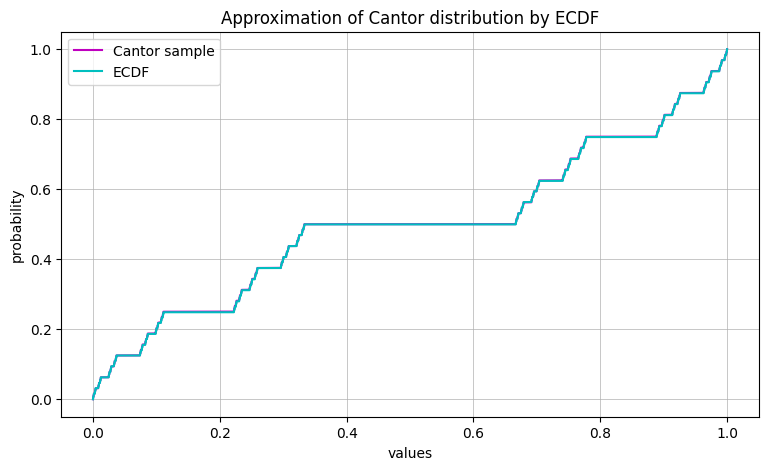

In [19]:
M = N // 2
grid = np.linspace(0, 1, M+1, endpoint=True)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.plot(sample_Cantor, cdf_Cantor, color='m', label='Cantor sample')
plt.plot(grid, ecdf_Cantor.cdf.evaluate(grid), color='c', label='ECDF')

plt.title('Approximation of Cantor distribution by ECDF')
plt.xlabel('values')
plt.ylabel('probability')
plt.legend()
plt.show()

__Теорема__ (Колмогоров) Пусть $X_1,X_2,\dots,X_n$ — н.о.р.с.в. с непрерывной функцией распределения $F(x)$. \
Пусть $F_n(x) = \frac{1}{n}\sum_{i=1}^n \mathbb{I}\{X_{(i)}<x\}$ — эмпирическая функция распределения (ECDF). \
Тогда 
$$
\forall x>0\quad \lim_{n\to\infty} \mathbb{P}({\sqrt{n}D_n < x}) = F_K(x),
$$
где $D_n=\sup\limits_{x\in\mathbb{R}}|F_n(x)-F(x)|$ — статистика Колмогорова и $F_K(\cdot)$ — функция распределения Колмогорова, которую можно выразить по формуле
$$
F_K(x) = 1 + 2 \sum_{k=1}^{+\infty}(-1)^k e^{-2k^2x^2}.
$$

Проверяем гипотезу
$$
H_0:~F(\cdot)=G(\cdot)
$$
с уровнем значимости $\alpha$, где $G=F_C(\cdot)$ — канторово распределение при помощи критерия Колмогорова.

Заметим, что $D_n$ является случайной величиной, ведь $F_n(x)$ зависит от реализации выборки. \
Теорема Колмогорова утверждает, что при истинности $H_0$ выполняется $\lim\limits_{n\to\infty} D_n = 0$, $\sqrt{n}D_n \sim F_K$ при $n\to\infty$.

Будем принимать $H_0$, если $1-F_K(\sqrt{n}D_n) > \alpha$.

In [20]:
def dist_Kolmogorov(x):
    '''
    Value of Kolmogorov distribution
    returns approximation of distribution value
    '''
    N = 300000
    res = [-2 * k * k * x * x for k in range(1,N+1)]
    res = np.exp(res)
    res = [(-1) ** k * res[k-1] for k in range(1,N+1)]
    return 1 + 2 * np.sum(res)

def stat_Kolmogorov(F_ecdf, F_cdf):
    '''
    Value of Kolmogorov statistic
    F_ecdf and F_cdf are vectors, must be of same length
    '''
    if not len(F_ecdf) == len(F_cdf):
        raise ValueError('Given vectors must be of same length.')
    return np.max(np.abs(F_ecdf - F_cdf))

def test_Kolmogorov(sample, cdf_at_sample):
    '''
    Kolmogorov test
    returns p-value 
    sample and cdf_at_sample are vectors, must be of same length
    '''
    if not len(sample) == len(cdf_at_sample):
        raise ValueError('Given vectors must be of same length.')
    n = len(sample)
    F_ecdf = ecdf(sample).cdf.evaluate(sample)
    stat = stat_Kolmogorov(F_ecdf, cdf_at_sample)
    norm_stat = np.sqrt(len(sample)) * stat
    p_value = 1 - dist_Kolmogorov(norm_stat)
    return p_value

Проверяем истинность гипотезы при помощи критерия Колмогова $\operatorname{n\_tests}=1000$ раз с уровнем значимости $\alpha=0.05$ для смоделированных датчиком $\texttt{rand\_Cantor}$ выборок размера $N=2000$ с погрешностью $\varepsilon=10^{-6}$.

In [21]:
n_tests = 1000
alpha = 0.05

N = 1000
eps = 1e-8

In [22]:
test_results_Kolmogorov = np.zeros(n_tests)
for i in range(n_tests):
    sample_Cantor, cdf_Cantor = rand_Cantor(N, eps)
    p_value = test_Kolmogorov(sample_Cantor, cdf_Cantor)
    test_results_Kolmogorov[i] = p_value

In [23]:
accept_count = np.count_nonzero((test_results_Kolmogorov > alpha).astype(int))
print('Null hypothesis is accepted in {:.4}% cases.'.format(100 * accept_count / n_tests))

Null hypothesis is accepted in 95.8% cases.


### Свойства канторового распределения

__Теорема__ (Смирнов) Пусть $X_1,X_2,\dots,X_n$ и $Y_1,Y_2,\dots,Y_m$, $m\leqslant n$ две независимые выборки, подчиняющиеся одному закону распределения $F(\cdot)\in C$, и $F_n(x),G_m(y)$ — соответствующие эмпирические функции распределения. Тогда
$$
\forall x\geqslant 0\quad \lim\limits_{n,m\to\infty}\mathbb{P}\left( \sqrt{\dfrac{nm}{n+m}}D_{nm} < x \right) = F_K(x),
$$
где $D_{nm} = \sup\limits_{x\in\mathbb{R}}|F_n(x) - G_m(x)|$ — статистика Смирнова и $F_K(\cdot)$ — функция распределения Колмогорова.


Пусть $X$  выборка, соответствующая канторовому распределения. 
1. Для проверки симметричности относительно $\frac{1}{2}$ выбираем $Y=1-X$.
2. Для проверки самоподобия относительно деления на 3 выбираем $\tilde{X}=\frac{X}{3}$, $Y=X$ при условии $X\in[0,\frac{1}{3}]$.

Проверяем гипотезу $H_0$ для двух выборок $X$ и $Y$ с функциями распределнения $F_X$ и $F_Y$:
$$
H_0:~ F_X(\cdot) = F_Y(\cdot) = F(\cdot)
$$
с уровнем значимости $\alpha$ при помощи критерия Смирнова.

Теорема Смирнова утверждает, что при истинности гипотезы $H_0$ верно $D_{nm}\to0$, $\sqrt{\frac{nm}{n+m}}D_{nm}\sim F_K$ при $n,m\to\infty$.

Будем принимать $H_0$, если $1-F_K(\sqrt{\frac{nm}{n+m}}D_n) > \alpha$.

In [24]:
def stat_Smirnov(sample_X, sample_Y):
    '''
    Smirnov statistic
    sample_X and sample_Y are vectors (of different length)
    '''
    n_points = 10**5
    grid = np.linspace(
        np.min([sample_X.min(), sample_Y.min()]),
        np.max([sample_X.max(), sample_Y.max()]),
        num=n_points,
        endpoint=True
    )
    ecdf_X = ecdf(sample_X).cdf.evaluate(grid)
    ecdf_Y = ecdf(sample_Y).cdf.evaluate(grid)
    return np.max(np.abs(ecdf_X - ecdf_Y))

def test_Smirnov(sample_X, sample_Y):
    '''
    Smirnov test
    returns p-value
    sample_X and sample_Y are vectors (of different length)
    '''
    n = len(sample_X)
    m = len(sample_Y)
    stat = stat_Smirnov(sample_X, sample_Y)
    norm_stat = np.sqrt(n*m / (n+m)) * stat
    p_value = 1 - dist_Kolmogorov(norm_stat)
    return p_value

Проверяем симметричность относительно $\frac{1}{2}$.

In [25]:
n_tests = 1000
alpha = 0.05

N = 10**3
eps = 1e-8

In [26]:
test_results_Smirnov = np.zeros(n_tests)
for i in range(n_tests):
    sample_Cantor_1, _ = rand_Cantor(N, eps)
    sample_Cantor_2, _ = rand_Cantor(N, eps)
    sample_Cantor_2 = 1 - sample_Cantor_2
    p_value = test_Smirnov(sample_Cantor_1, sample_Cantor_2)
    test_results_Smirnov[i] = p_value

In [27]:
accept_count = np.count_nonzero((test_results_Smirnov > alpha).astype(int))
print('Null hypothesis is accepted in {:.4}% cases.'.format(100 * accept_count / n_tests))

Null hypothesis is accepted in 95.4% cases.


In [28]:
sample_Cantor_1, cdf_Cantor_1 = rand_Cantor(N, eps)
sample_Cantor_2, _ = rand_Cantor(N, eps)
sample_Cantor_2 = 1 - sample_Cantor_2

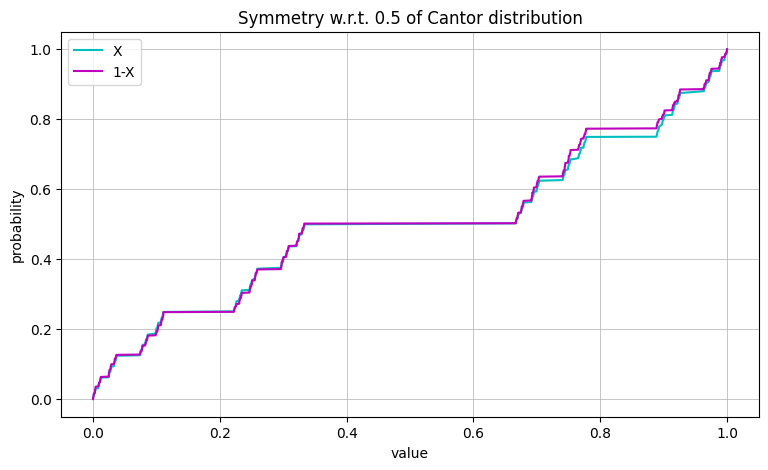

In [29]:
fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.plot(sample_Cantor_1, cdf_Cantor_1, color='c', label='X')
ax.plot(sample_Cantor_2, ecdf(sample_Cantor_2).cdf.evaluate(sample_Cantor_2), color='m', label='1-X')

plt.title('Symmetry w.r.t. 0.5 of Cantor distribution')
plt.xlabel('value')
plt.ylabel('probability')
plt.legend()
plt.show()

Проверяем самоподобие относительно деления на 3.

In [30]:
n_tests = 100
alpha = 0.05

N = 10**4
eps = 1e-12

In [31]:
test_results_Smirnov = np.zeros(n_tests)
for i in range(n_tests):
    sample_Cantor_1, _ = rand_Cantor(N, eps)
    sample_Cantor_1 = sample_Cantor_1 / 3
    sample_Cantor_2, _ = rand_Cantor(N, eps)
    sample_Cantor_2 = sample_Cantor_2[sample_Cantor_2 < 1/3]
    p_value = test_Smirnov(sample_Cantor_1, sample_Cantor_2)
    test_results_Smirnov[i] = p_value

In [32]:
accept_count = np.count_nonzero((test_results_Smirnov > alpha).astype(int))
print('Null hypothesis is accepted in {:.4}% cases.'.format(100 * accept_count / n_tests))

Null hypothesis is accepted in 94.0% cases.


In [33]:
sample_Cantor_1, _ = rand_Cantor(N, eps)
sample_Cantor_1 = sample_Cantor_1 / 3
sample_Cantor_2, _ = rand_Cantor(N, eps)
sample_Cantor_2 = sample_Cantor_2[sample_Cantor_2 < 1/3]

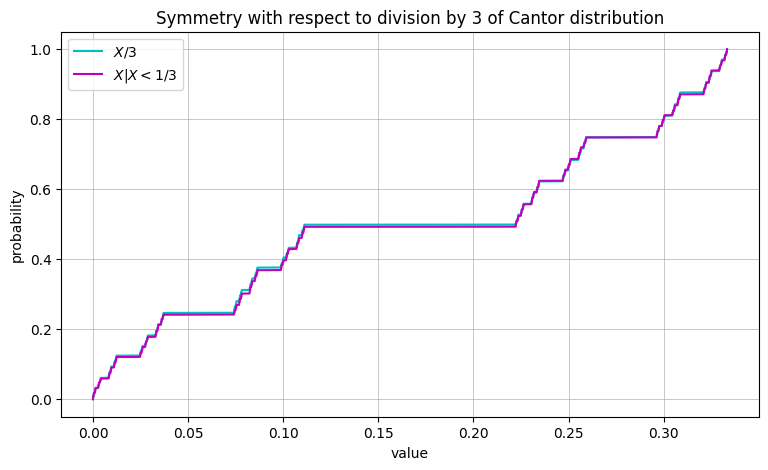

In [34]:
fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.plot(sample_Cantor_1, ecdf(sample_Cantor_1).cdf.evaluate(sample_Cantor_1), color='c', label='$X/3$')
ax.plot(sample_Cantor_2, ecdf(sample_Cantor_2).cdf.evaluate(sample_Cantor_2), color='m', label='$X|X<1/3$')

plt.title('Symmetry with respect to division by 3 of Cantor distribution')
plt.xlabel('value')
plt.ylabel('probability')
plt.legend()
plt.show()

### Численные характеристики канторового распределения

__Утверждение__ ([закон полной вариации](https://en.wikipedia.org/wiki/Law_of_total_variance))
Пусть $X,Y$ - случайные величины на одном вероятностном пространстве и $\mathbb{D}X<\infty$. Тогда
$$
\mathbb{D}X = \mathbb{E}[\mathbb{D}(X|Y)] + \mathbb{D}(\mathbb{E}[X|Y]).
$$

Доказательство.\
По телескопическому свойству условного математического ожидания и определению дисперсии имеем
$$
\begin{aligned}
\mathbb{D}X &= \mathbb{E}X^2 - (\mathbb{E}X)^2 = \mathbb{E}[\mathbb{E}[X^2|Y]] - (\mathbb{E}[\mathbb{E}[X|Y]])^2 = \\
&= \mathbb{E}[\mathbb{D}(X|Y) + (\mathbb{E}[X|Y])^2] - (\mathbb{E}[\mathbb{E}[X|Y]])^2 = \\
&= \mathbb{E}[\mathbb{D}(X|Y)] + \underbrace{(\mathbb{E}[(\mathbb{E}[X|Y])^2] - (\mathbb{E}[\mathbb{E}[X|Y]])^2)}_{=\mathbb{D}(\mathbb{E}[X~|~Y])}=\\
&= \mathbb{E}[\mathbb{D}(X|Y)] + \mathbb{D}(\mathbb{E}[X|Y]).
\end{aligned}
$$.
Свойства условного математического ожидания и их доказательство можно найти в [2].

1. Математическое ожидание $X\sim F_C$, $F_C$ - канторово, равно $\frac{1}{2}$:
$$
\begin{aligned}
\mathbb{E}X &= \{X\stackrel{d}{=}1-X \} = \mathbb{E}[1-X] \\ 
\Rightarrow~\mathbb{E}X &= 1 - \mathbb{E}X \\ 
\Rightarrow~\mathbb{E}X &= \frac{1}{2}.
\end{aligned}
$$

2. Дисперсия $X\sim F_C$ равна $\frac{1}{8}$:
$$
\begin{aligned}
Y &\stackrel{def}{=} \mathbb{I}\left\{ X\in\left[\frac{2}{3},1\right]\right\}. \\
\mathbb{D}X &= \mathbb{E}[\mathbb{D}(X~|~Y)] + \mathbb{D}(\mathbb{E}[X~|~Y]). \\
\mathbb{E}[\mathbb{D}(X~|~Y)] &= \frac{1}{9}\mathbb{D}X \text{ (из свойства самоподобия)}. \\
\mathbb{E}[X~|~Y] &= \begin{cases}\begin{array}{cc}
\frac{1}{6},~ \text{с вероятностью } \frac{1}{2}, \\
\frac{1}{2},~ \text{с вероятностью } \frac{1}{2}.
\end{array}\end{cases}\text{ (из свойства симметричности)} \\
\mathbb{D}X &= \frac{1}{9}\mathbb{D}X + \frac{1}{9} \\
\Rightarrow~ \mathbb{D}X &= \frac{1}{8}.
\end{aligned}

In [52]:
N_start = 10**3
N_end = 10**5 + N_start
step = 5 * 1000
eps = 1e-12

In [53]:
iter_count = (N_end - N_start) // step + 1
mean_convergence_results = np.zeros(iter_count)
var_convergence_results = np.zeros(iter_count)
for i in range(0, iter_count):
    N_curr = N_start + i * step
    sample_Cantor, _ = rand_Cantor(N_curr, eps)
    mean_convergence_results[i] = sample_Cantor.mean()
    var_convergence_results[i] = sample_Cantor.var()

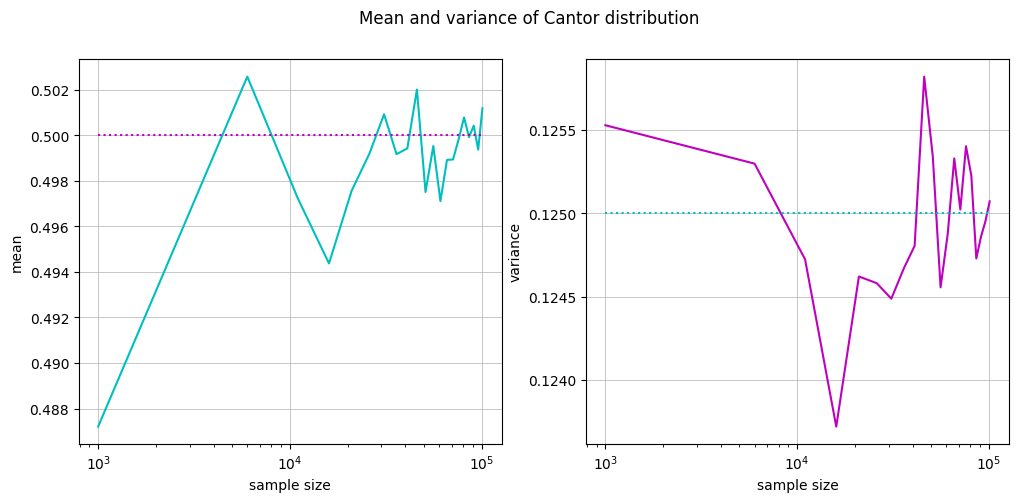

In [56]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,5))

grid = np.arange(N_start, N_end + 1, step)

ax[0].grid('minor', linewidth=0.5)
ax[0].plot(grid, mean_convergence_results, color='c')
ax[0].hlines(0.5, N_start, N_end, linestyle='dotted', color='m')
ax[0].set_xlabel('sample size')
ax[0].set_ylabel('mean')
ax[0].set_xscale('log')

ax[1].grid('minor', linewidth=0.5)
ax[1].plot(grid, var_convergence_results, color='m')
ax[1].hlines(0.125, N_start, N_end, linestyle='dotted', color='c')
ax[1].set_xlabel('sample size')
ax[1].set_ylabel('variance')
ax[1].set_xscale('log')

fig.suptitle('Mean and variance of Cantor distribution')
plt.show()

## Задание 3

### Условие

1. Построить датчик экспоненциального распределения. Проверить для данного
распределения свойство остутствия памяти.

2. Пусть $X_1,X_2,\dots,X_n$ --- независимые экспоненциально распределенные случайные величины с параметрами
$\lambda_1,\lambda_2,\dots,\lambda_n$. Найти распределение случайной величины $Y=\min\{X_1,X_2,\dots,X_n\}$.

3. На основе датчика экспоненциального распределения построить датчик пуассоновского распределения.

4. Построить датчик пуассоновского распределения как предел биномиального распределения. Убедиться в корректности
построенного датчика при помощи критерия $\chi^2$ Пирсона.

5. Построить датчик стандартного нормального распределения методом моделирования случайных величин парами с переходом в полярные координаты 
(преобразование Бокса-Мюллера). Проверить при помощи t-критерия Стьюдента равенство математических ожиданий, а при помощи критерия Фишера — 
равенство дисперсий.

### Генератор экспоненциального распределения

Экспоненциальное распределение - абсолютно непрерывное распределение с плотностью $\lambda e^{-\lambda x},~\lambda>0$.

Рассмотрим $\lambda > 0$. Будем генерировать случайную величину
$$
\xi = -\frac{1}{\lambda}\ln\nu,\quad \nu\sim\mathrm{U}[0,1].
$$
Она имеет экспоненциальное распределение $\mathrm{Exp}(\lambda)$, ведь
$$
\mathbb{P}(\xi < x) = \mathbb{P}(-\frac{1}{\lambda}\ln\nu < x) = \mathbb{P}(\nu > e^{-\lambda x}) = 1 - e^{-\lambda x}.
$$

In [57]:
def rand_expo(l, *args):
    '''
    Exponential distribution generator
    returns tensor with given shapes
    l - parameter, must be positive
    args consists of positive integer numbers (resulting dimensions)
    dimension error handling in np.random.rand
    '''
    if not l > 0:
        raise ValueError('Parameter of exponential distribution must be a positive float number.')
    return -np.log(np.random.rand(*args)) / l

In [58]:
L = 0.5
N = 10**5
sample_exponential = rand_expo(L, N)

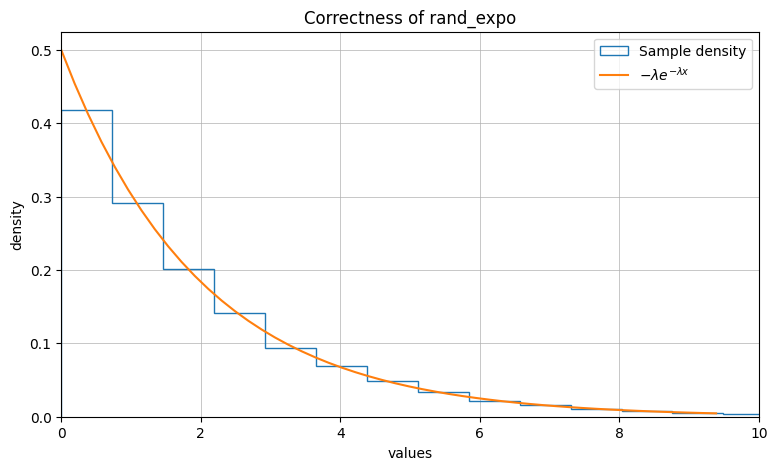

In [59]:
n_bins = 30

alpha = 0.01
xlim = np.ceil(-np.log(alpha)/L)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)
ax.set_xlim([0, xlim])

x = np.linspace(0, sample_exponential.max() * 3/7)
ax.hist(sample_exponential, 
    bins=n_bins,
    density=True, 
    histtype='step', 
    label='Sample density'
)
ax.plot(x, L * np.exp(-L * x), label='$-\lambda e^{-\lambda x}$')

plt.title('Correctness of rand_expo')
plt.ylabel('density')
plt.xlabel('values')
plt.legend()
plt.show()

Проверим свойство отсутствия памяти аналогично геометрическому распределению.

In [60]:
L = 0.5
N = 10**6
m = 5

In [61]:
sample_expo_1 = rand_expo(L, N)
sample_expo_2 = rand_expo(L, N)
sample_expo_2 = sample_expo_2[sample_expo_2 > m]

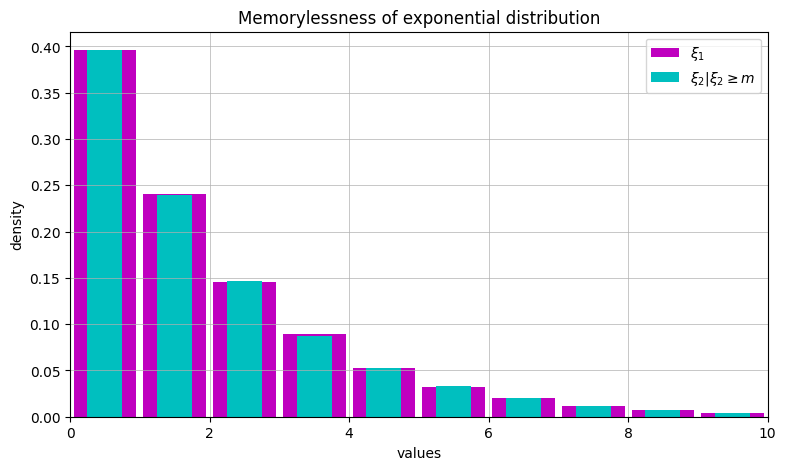

In [62]:
alpha = 0.01
xlim = np.ceil(-np.log(alpha)/L)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)
ax.set_xlim([0, xlim])

ax.hist(sample_expo_1, density=True, rwidth=0.9, range=(0, xlim), color='m', label='$\\xi_1$')
ax.hist(sample_expo_2 - m, density=True, rwidth=0.5, range=(0, xlim), color='c', label='$\\xi_2|\\xi_2\\geq m$')

plt.title('Memorylessness of exponential distribution')
plt.ylabel('density')
plt.xlabel('values')
plt.legend()
plt.show()

### Распределение $Y=\min\{X_1,X_2,\dots,X_n\}$.

Имеем
$$
X_k \sim \mathrm{Exp}(\lambda_k),~ k\in\overline{0,n} \text{ --- i.i.d.r.v.}
$$

Генератор строим из следующих соображений.
$$
\begin{aligned}
\mathbb{P}(Y < x) &= 1 - \mathbb{P}(\min\{X_1,X_2,\dots,X_n\} \geqslant x) = \\
&= 1 - \mathbb{P}(X_1 \geqslant x, X_2 \geqslant x, \dots, X_n \geqslant x) = \{\text{независимость}\} = \\
&= 1 - \prod_{k=1}^{n}\mathbb{P}(X_k \geqslant x) = 1 - \prod_{k=1}^{n}(1 - \mathbb{P}(X_k < x)) = \\
&= 1 - \prod_{k=1}^{n}e^{-\lambda_kx} = 1 - e^{-(\lambda_1+\lambda_2+\dots+\lambda_n)x}.
\end{aligned}
$$
Получили, что $Y\sim\mathrm{Exp}(\sum_{k=1}^n\lambda_k)$.

Докажем полученное эмпирически. \
Для этого построим эмпирические функции распределения $Y$ по явной формуле и $Y$ как экспоненциальное распределение.

In [63]:
def gen_minimum_expo(lambdas, *args):
    '''
    Y=\min{X_1,X_2,...,X_n}, X_i~Exp(\lambda_i) generator
    returns tensor with given shapes
    lambdas - vector of positive parameters of length n
    args consists of positive integer numbers (resulting dimensions)
    error handling in rand_expo
    '''
    n = len(lambdas)
    X = np.empty([n, *args])
    for k in range(n):
        X[k] = rand_expo(lambdas[k], *args)
    return np.min(X, axis=0)

In [64]:
N = 10**5
n = 100
lambdas = 7 * np.random.rand(n)

In [65]:
Y_sample_1 = gen_minimum_expo(lambdas, N)
Y_sample_2 = rand_expo(lambdas.sum(), N)

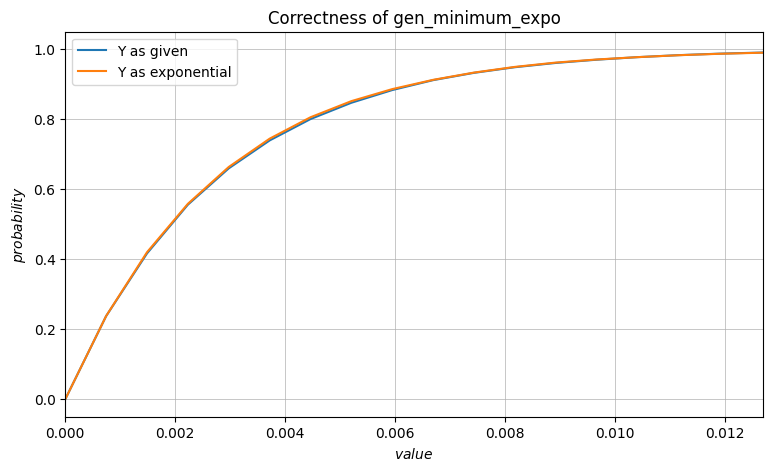

In [66]:
alpha = 0.01
xlim = -np.log(alpha)/lambdas.sum()

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)
ax.set_xlim([0, xlim])

grid = np.linspace(0, max(Y_sample_1.max(), Y_sample_2.max()))
ecdf_expo_1 = ecdf(Y_sample_1).cdf.evaluate(grid)
ecdf_expo_2 = ecdf(Y_sample_2).cdf.evaluate(grid)
ax.plot(grid, ecdf_expo_1, label='Y as given')
ax.plot(grid, ecdf_expo_2, label='Y as exponential')

plt.title('Correctness of gen_minimum_expo')
plt.ylabel('$probability$')
plt.xlabel('$value$')
plt.legend()
plt.show()

### Генератор пуассоновского распределения (через г-р экспоненциального р-я)

Пуассоновская случайная величина $X$ с параметром $\lambda > 0$ принимает значения $k\in\{0,1,2,\dots\}\equiv\mathbb{N}_0$, является дискретной:
$$
\mathbb{P}(X = k) = e^{-\lambda}\dfrac{1}{k!}\lambda^k.
$$
Причём $\mathbb{E}X=\mathbb{D}X=\lambda$.

Воспользуемся следующей теоремой.

__Теорема__. Пусть $X_1,X_2,\dots,X_n$ - н.о.р.с.в., $X_i\sim\mathrm{Exp}(\lambda),\lambda>0$. \
Положим $Y$ - наименьшее неотрицательное целое число такое, что
$$
\sum_{k=1}^{Y+1}X_i > 1.
$$
Тогда $Y\sim\mathrm{Pois}(\lambda)$.

Доказательство можно найти в [3], с.501 (ошибка в формулировке теоремы)

In [67]:
def rand_poisson_expo(l):
    '''
    Poisson distribution generator, derivative of rand_expo
    returns realization of one random value
    l - parameter, must be positive
    error handling in rand_expo
    '''
    Y = 0
    summ = 0
    while True:
        summ += rand_expo(l)
        if summ > 1:
            return Y
        else:
            Y += 1

def rand_poisson_expo_vec(l, *args):
    '''
    Poisson distribution generator, derivative of rand_expo
    returns tensor with given shapes
    l - parameter, must be positive
    args consists of positive integer numbers (resulting dimensions)
    error handling in rand_expo
    '''
    if not args:
        return rand_poisson_expo(l)
    else:
        Y = np.zeros(*args)
        summ = np.zeros(*args)
    while True:
        X = rand_expo(l, *args)
        summ = summ + X
        Y[summ < 1] = Y[summ < 1] + 1
        if not np.any(Y[summ < 1]):
            return Y

In [68]:
N = 10**5
L = 10

In [69]:
sample_poisson_expo = rand_poisson_expo_vec(L, N)
print(f'mean={sample_poisson_expo.mean():.6}, variance={sample_poisson_expo.var():.6}')

mean=9.99007, variance=10.0074


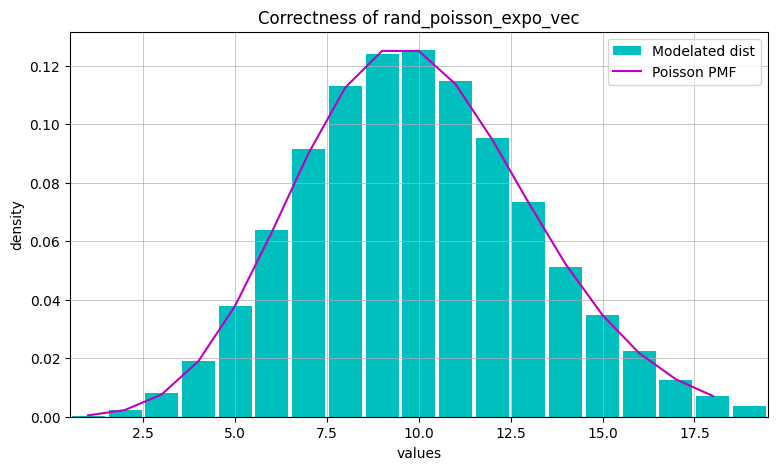

In [70]:
n_bins = 19
grid = np.arange(np.ceil(L - 3*np.sqrt(L)), np.floor(L + 3*np.sqrt(L)))

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)
ax.set_xlim([L - 3*np.sqrt(L), L + 3*np.sqrt(L)])

ax.hist(sample_poisson_expo,
    bins=n_bins,
    density=True,
    rwidth=0.9,
    range=(L - 3*np.sqrt(L), L + 3*np.sqrt(L)),
    label='Modelated dist',
    color='c'
)
ax.plot(grid, poisson.pmf(grid, mu=L), color='m', label='Poisson PMF')

plt.title('Correctness of rand_poisson_expo_vec')
plt.ylabel('density')
plt.xlabel('values')
plt.legend()
plt.show()

### Генератор пуассоновского распределения (через г-р биномиального р-я)

Воспользуемся Теоремой Пуассона.

__Теорема__ (Пуассон). Пусть есть последовательность биномиально распределенных случайных величин $X_n\sim\mathrm{Bin}(n, p_n)$ такая, что
1. $n\to\infty$.
2. $np_n\to\lambda,~n\to\infty$.

Тогда $\lim\limits_{n\to\infty}\mathbb{P}(X_n = m) = \dfrac{\lambda^m}{m!}e^{-\lambda}$.

Доказательство приведено в [2], Гл. I, §6, п.4.

Будем моделировать выборку-вектор пуассоновского распределения при помощи последовательного запуска $\texttt{rand\_bin}$.

In [71]:
def rand_poisson_bin(l, N):
    '''
    Poisson distribution generator, derivative of rand_bin
    returns vector of length N
    l - parameter, must be positive
    '''
    if not l > 0:
        raise ValueError('Parameter of exponential distribution must be a positive float number.')
    if not isinstance(N, (int, np.integer)) or N <= 0:
        raise ValueError('Resulting vector length must be a positive integer.')
    n = 10**4
    p_n = l / n
    batch_size = 5 * 10**3
    result = np.zeros(N)
    for i in range(0, N // batch_size + 1):
        if (i+1)*batch_size >= N:
            result[i*batch_size:] = rand_bin(n, p_n, N - i*batch_size)
        else:
            result[i*batch_size:(i+1)*batch_size] = rand_bin(n, p_n, batch_size)
    return result

In [72]:
N = 10**6
L = 12

In [73]:
sample_poisson_bin = rand_poisson_bin(L, N)

In [74]:
print(f'mean={sample_poisson_bin.mean():.6}, variance={sample_poisson_bin.var():.6}')

mean=11.9982, variance=11.9799


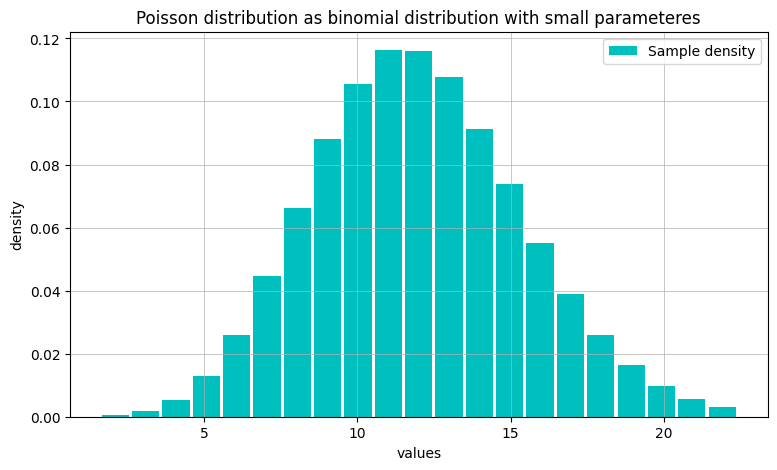

In [75]:
n_bins = 21

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.hist(sample_poisson_bin,
    bins=n_bins,
    density=True,
    label='Sample density',
    range=(L - 3*np.sqrt(L), L + 3*np.sqrt(L)),
    rwidth=0.9,
    color='c'
)

plt.title('Poisson distribution as binomial distribution with small parameteres')
plt.ylabel('density')
plt.xlabel('values')
plt.legend()
plt.show()

Проверяем гипотезу о виде функции распределения $X$ при помощи критерия $\chi^2$ Пирсона:
$$
H_0:~ F_X(\cdot) = F_{\operatorname{Pois}}(\cdot)
$$
с уровнем значимости $\alpha$, где $F_{\operatorname{Pois}}(\cdot)$ - функция распределения $\mathrm{Pois}(10)$.

Выберем разбиение $T$ размера $m=15$ области определения распределения ($\mathbb{N}_0$):
$$
T = \bigcup_{k=1}^{15} T_k,~
T_1 = \{0,1,2,3,4\},~T_k=\{k+3\},k=\overline{2,14},~T_{15}=\{k\geqslant18\}.
$$
Вычисляем теоретические вероятности $p_k=\mathbb{P}(X \in T_k)$ при условии истинности $H_0$. \
Вычисляем $l_k$ - число попаданий значений выборки $X$ в множество $T_k$.

Согласно критерию $\chi^2$ Пирсона при истинности гипотезы $H_0$ статистика $\chi^2$:
$$
\chi^2 = \sum^{m}_{k=1} \dfrac{(l_k - np_k)^2}{np_k} = \sum^{m}_{k=1}\dfrac{n}{p_k}\left( \dfrac{l_k}{n} - p_k \right)^2.
$$
имеет распределение $\chi^2_{m-1}$.

Будем принимать гипотезу, если $1-F_{\chi^2_{m-1}}(\chi^2) > \alpha$.

In [76]:
def stat_chi2(sample_size, model_freqs, teor_freqs):
    '''
    Chi2 statistic
    sample_size is positive integer
    model_freqs and teor_freqs are vectors of same length and values in [0,1]
    '''
    if not isinstance(sample_size, (int, np.integer)) or sample_size <= 0:
        raise ValueError('Sample size must be a positive integer.')
    if model_freqs.min() < 0 or model_freqs.max() > 1:
        raise ValueError('Model frequencies must be in range [0,1].')
    if teor_freqs.min() < 0 or teor_freqs.max() > 1:
        raise ValueError('Model frequencies must be in range [0,1].')
    if len(model_freqs) != len(teor_freqs):
        raise ValueError('Given vectors must be of same length.')
    squares = np.power(model_freqs - teor_freqs, 2)
    return np.sum(np.divide(N * squares, teor_freqs))

def test_chi2(sample_size, model_freqs, teor_freqs):
    '''
    Chi-square test
    returns p-value
    sample_size is positive integer
    model_freqs and teor_freqs are vectors of same length and values in [0,1]
    error handling in stat_chi2
    '''
    stat = stat_chi2(sample_size, model_freqs, teor_freqs)
    p_value = 1 - chi2.cdf(stat, df=len(model_freqs))
    return p_value

def count_matches(target, values):
    target_set = set(target)
    return sum(1 for value in values if value in target_set)

In [77]:
n_tests = 100
alpha = 0.05

L = 10
N = 10**4

split_size = 15
split_lower_bound = 4
split_upper_bound = split_size + split_lower_bound - 1
pmf_upper_bound = 40

In [78]:
# calculate teoretical frequencies
poisson_pmf = poisson.pmf(np.arange(0, pmf_upper_bound), mu=L)
teor_freqs = np.zeros(split_size)
teor_freqs[0] = poisson_pmf[:split_lower_bound+1].sum()
teor_freqs[1:split_size-1] = poisson_pmf[split_lower_bound+1:split_upper_bound]
teor_freqs[-1] = poisson_pmf[split_upper_bound:].sum()

In [79]:
test_results_Pearson = np.zeros(n_tests)

T_1 = np.arange(0, split_lower_bound+1)

for i in range(n_tests):
    model_freqs = np.zeros(split_size)
    sample_poisson_bin = rand_poisson_bin(L, N)
    # calculate modelated frequencies
    model_freqs = np.zeros(split_size)
    model_freqs[0] = count_matches(T_1, sample_poisson_bin) / N
    for k in range(1, split_size):
        model_freqs[k] = np.count_nonzero((sample_poisson_bin == split_lower_bound + k).astype(int)) / N
    model_freqs[-1] = np.count_nonzero((sample_poisson_bin >= split_upper_bound).astype(int)) / N
    # calculate p-value
    p_value = test_chi2(N, model_freqs, teor_freqs)
    test_results_Pearson[i] = p_value

In [80]:
accept_count = np.count_nonzero((test_results_Pearson > alpha).astype(int))
print('Null hypothesis is accepted in {:.4}% cases.'.format(100 * accept_count / n_tests))

Null hypothesis is accepted in 94.0% cases.


### Генератор стандартного нормального распределения (преобразование Бокса-Мюллера)

__Теорема__ Пусть $\xi_1,\xi_2$ - независимые стандартно нормально распределенные случайные величины.
Тогда их можно представить в виде
$$
\begin{cases}
\xi_1 = \sqrt{\omega}\cos\nu,\\
\xi_2 = \sqrt{\omega}\sin\nu.
\end{cases}
$$
где $\nu\sim\mathrm{U}[0,2\pi], \omega\sim\mathrm{Exp}(\frac{1}{2})$ - независимые.

Доказательство. \
Покажем, что совместные плотности векторов $(\xi_1,\xi_2), (\sqrt{\omega}\cos\nu, \sqrt{\omega}\sin\nu)$ совпадают. \
Для этого достаточно перейти к полярным координатам под знаком интеграла:
$$
\begin{aligned}
\mathbb{P}(X_1<x, X_2<y) &= \int_{-\infty}^{x}\int_{+\infty}^{y} \dfrac{1}{2\pi}e^{-\frac{x_1^2+x_2^2}{2}}dx_2dx_1 = \\
&= \biggl\vert \begin{array}{c}
x_1 = r\cos\alpha, \\ 
x_2 = r\sin\alpha.
\end{array} \biggr\vert = \iint\limits_{\begin{array}{c}r\cos\alpha<x\\ r\sin\alpha<y\end{array}} \dfrac{1}{2\pi}e^{-\frac{r^2}{2}}rdrd\alpha = \\
&= \{ \omega = r^2, d\omega = 2rdr \} = \\
&= \iint\limits_{\begin{array}{c}\sqrt{\omega}\cos\alpha<x\\ \sqrt{\omega}\sin\alpha<y\end{array}} \dfrac{1}{2\pi}e^{-\frac{\omega}{2}}\frac{1}{2}d\omega d\alpha = \mathbb{P}(\xi_1 < x, \xi_2 < y).
\end{aligned}
$$

In [81]:
def rand_norm_expo(*args):
    '''
    Standard normal distribution generator, derivative of rand_expo
    returns tensor with given shapes
    shapes error handling in rand_expo
    '''
    omega = rand_expo(0.5, *args)
    alpha = 2 * np.pi * np.random.rand(*args)
    return np.sqrt(omega) * np.cos(alpha)

def rand_norm_pair(*args):
    '''
    Standard normal distribution generator, derivative of rand_expo
    returns pair of tensors with given shapes
    shapes error handling in rand_expo
    '''
    omega = rand_expo(0.5, *args)
    alpha = 2 * np.pi * np.random.rand(*args)
    return np.sqrt(omega) * np.cos(alpha), np.sqrt(omega) * np.sin(alpha)

In [ ]:
N = 10**6
mu = 0
sigma = 1

In [83]:
sample_norm_expo = rand_norm_expo(N)

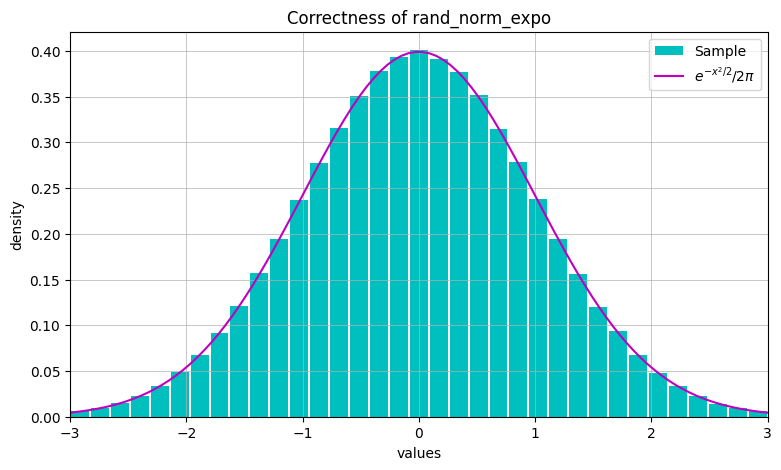

In [85]:
n_bins = 35
grid_size = 100
grid = np.linspace(mu - 3*sigma, mu + 3*sigma, grid_size)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)
ax.set_xlim([mu - 3*sigma, mu + 3*sigma])

ax.hist(sample_norm_expo, bins=n_bins, density=True, range=(mu - 3*sigma, mu + 3*sigma), rwidth=0.9, color='c', label='Sample')
ax.plot(grid, norm.pdf(grid, loc=mu, scale=sigma), color='m', label='$e^{-x^2/2}/2\pi$')

plt.title('Correctness of rand_norm_expo')
plt.ylabel('density')
plt.xlabel('values')
plt.legend()
plt.show()

__Утверждение__ (Стьюдент) \
Пусть $X_1,X_2,\dots,X_n$ - независимые случайные величины такие, что $X_i\sim\mathrm{N}(\mu,\sigma^2), i=\overline{1,n}$.
Положим $\overline{X}$ - выборочное среднее, $S^2$ - несмещенная выборочная дисперсия. Тогда
$$
T=\dfrac{\overline{X}-\mu}{S/\sqrt{n}}\sim t(n-1),
$$
где $t(n-1)$ - распределение Стьюдента с $(n-1)$ степенями свободы.

Проверяем гипотезу о равенстве мат. ожидания конкретному значению одной нормально распределенной выборки при помощи t-критерия Стьюдента:
$$
H_0:~ \mathbb{E}X = \mu.
$$

Согласно утверждению Стьюдента при истинности гипотезы $H_0$ статистика $T$ имеет распределение $t(n-1)$. \
Отметим, что критерий Стьюдента имеет двустороннюю критическую область.

Будем принимать $H_0$, если $|T| < K_\alpha = F^{-1}_{t(n-1)}(1-\alpha/2)$.

Нужные значения возьмём из [таблицы](https://ru.wikipedia.org/wiki/%D0%9A%D0%B2%D0%B0%D0%BD%D1%82%D0%B8%D0%BB%D0%B8_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F_%D0%A1%D1%82%D1%8C%D1%8E%D0%B4%D0%B5%D0%BD%D1%82%D0%B0): при $\alpha=0.05, n=10^4 + 1$ квантиль $K_\alpha = 1.9623$.

In [103]:
def stat_Student(sample, loc=0.0):
    '''
    Student statistic
    '''
    sample_mean = sample.mean()
    sample_std = sample.std(ddof=1)     # ddof=1 for division by sqrt(n-1)
    return (sample_mean - loc) / (sample_std / np.sqrt(len(sample)))

def test_Student(sample, quantile, loc=0.0):
    '''
    Student test
    takes sample and critical quantile
    '''
    stat = stat_Student(sample, loc)
    return np.abs(stat) < quantile

In [106]:
n_tests = 10**3
t_quantile = 1.9623

mu = 2.5
sigma = 1.25
N = 10**5

In [107]:
test_results_Student = np.zeros(N)
for i in range(n_tests):
    sample_norm = sigma * rand_norm_expo(N) + mu
    test_results_Student[i] = test_Student(sample_norm, t_quantile, mu)

In [108]:
accept_count = np.count_nonzero(test_results_Student.astype(int))
print('Null hypothesis is accepted in {:.4}% cases.'.format(100 * accept_count / n_tests))

Null hypothesis is accepted in 95.3% cases.


Проверяем гипотезу о равенстве дисперсий двух независимых нормально распределенных выборок при помощи критерия Фишера:
$$
H_0:~ \mathbb{D}X = \mathbb{D}Y = \sigma^2.
$$

При истинности гипотезы $H_0$ для выборок $X$ (размера $n$) и $Y$ (размера $m$) статистика
$$
D = \dfrac{S^2_X}{S^2_Y} \sim F(m-1,n-1),
$$
где $F(m-1,n-1)$ - распределение Фишера со степенями свободы $n-1$ и $m-1$. \
Отметим, что критерий Фишера также имеет двустороннюю критическую область.

Будем принимать $H_0$, если $D\in (K_{\alpha/2}, K_{1-\alpha/2})$, где $K_{\alpha/2}=F^{-1}_{F(n-1,m-1)}(\alpha/2), K_{1-\alpha/2}=F^{-1}_{F(n-1,m-1)}(1-\alpha/2)$.

In [109]:
def stat_Fisher(sample_X, sample_Y):
    '''
    Fisher statistic
    sample_X and sample_Y are vectors (of different length)
    '''
    sample_X_var = np.var(sample_X, ddof=1) # ddof=1 for division by sqrt(n-1)
    sample_Y_var = np.var(sample_Y, ddof=1)
    return sample_X_var / sample_Y_var

def test_Fisher(sample_X, sample_Y, alpha):
    '''
    Fisher test
    returns boolean value of hypothesis acceptance
    sample_X and sample_Y are vectors (of different length)
    '''
    N = len(sample_X)
    M = len(sample_Y)
    stat = stat_Fisher(sample_X, sample_Y)
    # we use percent point function of central F-distribution
    # best practice is to compute quantiles only once
    # but documentation says that test_ functions must contain alpha as parameter
    f_quantile_1 = f.ppf(alpha/2, N-1, M-1)
    f_quantile_2 = f.ppf(1 - alpha/2, N-1, M-1)
    return stat > f_quantile_1 and stat < f_quantile_2

In [110]:
mu = 2.5
sigma = 1.25
N = 6000
M = 10000

n_tests = 10**3
alpha = 0.05

In [111]:
test_results_Fisher = np.zeros(n_tests)
for i in range(n_tests):
    sample_X = sigma * rand_norm_expo(N) + mu
    sample_Y = sigma * rand_norm_expo(M) + mu
    test_results_Fisher[i] = test_Fisher(sample_X, sample_Y, alpha)

In [112]:
accept_count = np.count_nonzero(test_results_Fisher.astype(int))
print('Null hypothesis is accepted in {:.4}% cases.'.format(100 * accept_count / n_tests))

Null hypothesis is accepted in 95.8% cases.


## Задание 4

### Условие

1. Построить датчик распределения Коши.

2. На основе датчика распределения Коши с помощью метода фон Неймана построить датчик стандартного нормального распределения. При помощи 
графика normal probability plot убедиться в корректности построенного датчика и обосновать наблюдаемую линейную зависимость.

3. Сравнить скорость моделирования стандартного нормального распределения в задании 3 и в задании 4.

### Генератор распределения Коши

Распределение Коши $\mathrm{C}(x_0,\gamma)$ - абсолютно непрерывное распределение с плотностью
$$
\dfrac{1}{\pi\gamma\left(1+(\frac{x-x_0}{\gamma})^2 \right)},
$$
где $x_0$ - параметр сдвига, $\gamma>0$ - параметр масштаба.

Пусть $X\sim\mathrm{C}(x_0,\gamma)$. Тогда
$$
\begin{aligned}
F_X(x) &= \dfrac{1}{\pi}\operatorname{arctg}\left(\dfrac{x-x_0}{\gamma}\right) + \dfrac{1}{2}, \\
F_X^{-1}(x) &= x_0 + \gamma\tg\left[\pi\left(x-\dfrac{1}{2}\right)\right].
\end{aligned}
$$

In [113]:
def rand_Cauchy(loc=0.0, scale=1.0, *args):
    '''
    Cauchy distribution generator
    returns tensor with given shapes
    loc - shift parameter
    scale - scale parameter, must be positive
    shapes error handling in rand_expo
    '''
    if not scale > 0:
        raise ValueError('Scale must be a positive float number.')
    return loc + scale * np.tan(np.pi * (np.random.rand(*args) - 0.5))

Продемонстрируем отсутствие математического ожидания у распределения Коши.

In [114]:
loc = 5
scale = 2

n_runs = 200
N = 10**6

In [115]:
runs_results = np.zeros(n_runs)
for i in range(n_runs):
    sample_Cauchy = rand_Cauchy(loc, scale, N)
    runs_results[i] = sample_Cauchy.mean()

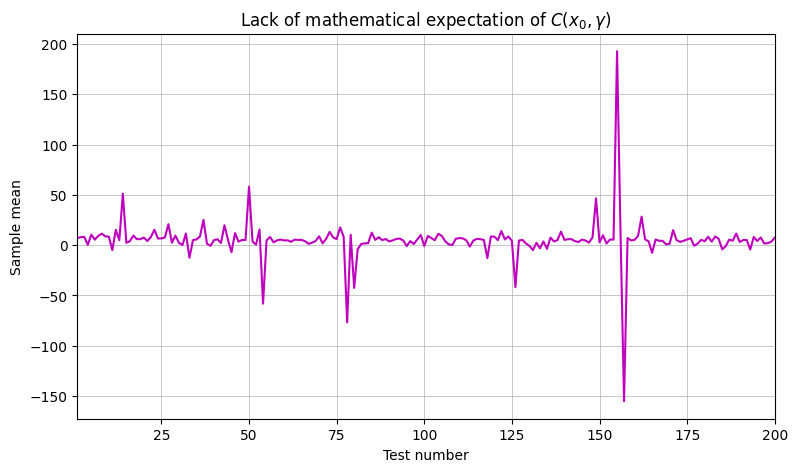

In [124]:
n_bins = 30

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)
ax.set_xlim([1, n_runs])

ax.plot(np.arange(1, n_runs+1), runs_results, c='m')

plt.title('Lack of mathematical expectation of $C(x_0,\gamma)$')
plt.ylabel('Sample mean')
plt.xlabel('Test number')
plt.show()

### Генератор стандартного нормального распределения (через г-р распределения Коши)

Метод элиминации фон Нейманна: \
Ставится задача моделирования распределения с плотностью $f(x)$ со значениями в $\mathbb{R}^n.$ \
Пусть имеются $X\sim g(x)$ и $U\sim \mathrm{U}[0,1]$ - две случайные величины, $g(x)$ принимает значения в $\mathbb{R}^n$. \
Также имеется константа $c\geqslant 1$.

Можно показать, что случайный вектор $(X, cUg(X))\sim\mathrm{U}(A)$, где $A=\{(x,u)~|~x\in\mathbb{R}^n,0\leqslant u\leqslant cf(x)\}$.

Алгоритм моделирования на псевдокоде:
```python
while True
    X = ... # моделируем X
    U = ... # моделируем U
    T = c * g(X) / f(X)
    if U*T <= 1:
        break
```

Доказательство, обоснование корректности приведены в [3], с. 40-46.

Обоснованность алгоритма моделирования для $f(x)=\dfrac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}$ приведена там же, с. 46.

In [125]:
def rand_norm_Cauchy():
    '''
    Standard normal distribution generator, derivative of rand_expo
    returns realization of one random value
    implemented rejection sampling method
    '''
    alpha = np.sqrt(np.exp(1)) / 2
    while True:
        X = rand_Cauchy(0, 1)
        U = np.random.rand()
        S = X * X
        if U < alpha * (1 + S) * np.exp(-S/2):
            return X

In [126]:
N = 10**6
sample_norm_Cauchy = np.zeros(N)
for i in range (1, N+1):
    sample_norm_Cauchy[i-1] = rand_norm_Cauchy()

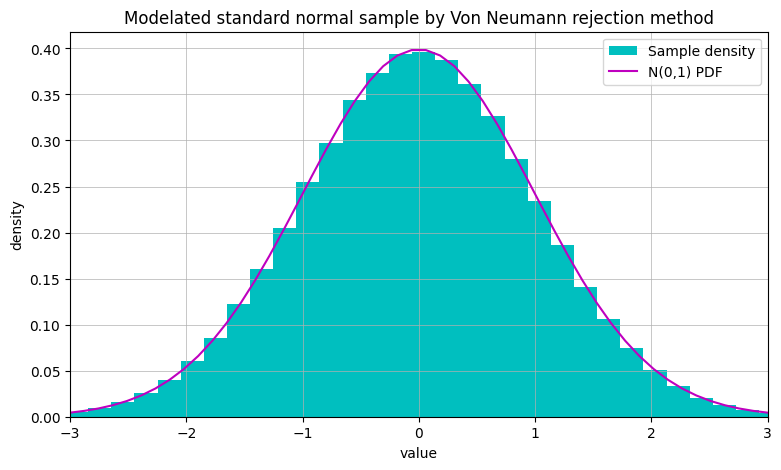

In [127]:
n_bins = 50
grid = np.linspace(-3, 3)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)
ax.set_xlim([-3, 3])

ax.hist(sample_norm_Cauchy, bins=n_bins, density=True, color='c', label='Sample density')
ax.plot(grid, norm.pdf(grid), color='m', label='N(0,1) PDF')

plt.title('Modelated standard normal sample by Von Neumann rejection method')
plt.ylabel('density')
plt.xlabel('value')
plt.legend()
plt.show()

Функция $\texttt{scipy.stats.probplot}$ строит Q-Q plot (quantile-quantile plot). \
Он определяется следующим образом.
- По оси ординат откладывается выборка в возрастающем порядке.
- По оси абсцисс откладываются теоретические квантили заданного распределения (в данном случае нормального).

Подсчет теоретических квантилий осуществляется при помощи преобразования Филлибена, ведь возникает проблема их вычисления для выборок малого размера.

Таким образом, чтобы проверить данные на нормальность, достаточно взглянуть на линейный порядок сортированных данных на Q-Q графике.

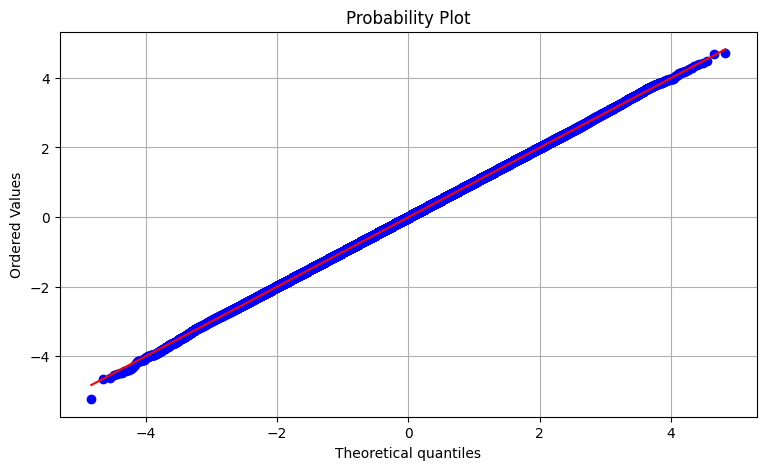

In [128]:
fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor')
probplot(sample_norm_Cauchy, dist='norm', fit=True, plot=ax)
plt.show()

### Сравнение скорости сходимости

In [129]:
step = 100
n_start = 10000
n_end = n_start + 1000
iter_count = (n_end - n_start) // step + 1      # count of iterations for one sample

runs_count = 100                                # count of runs at iteration for time measuring

time_expo = np.zeros(iter_count)
time_Cauchy = np.zeros(iter_count)
results = np.zeros(runs_count)

# measure rand_norm_expo, rand_norm_Cauchy
for i in range(iter_count):
    sample_size = n_start + i * step
    sample = np.zeros(sample_size)

    # fill time_expo, find the median of calculation time
    for j in range(runs_count):
        t = time()
        for k in range(sample_size):
            sample[k] = rand_norm_expo()
        results[i] = time() - t
    time_expo[i] = results.mean()

    # fill time_Cauchy, find the median of calculation time
    for j in range(runs_count):
        t = time()
        for k in range(sample_size):
            sample[k] = rand_norm_Cauchy()
        results[i] = time() - t
    time_Cauchy[i] = results.mean()

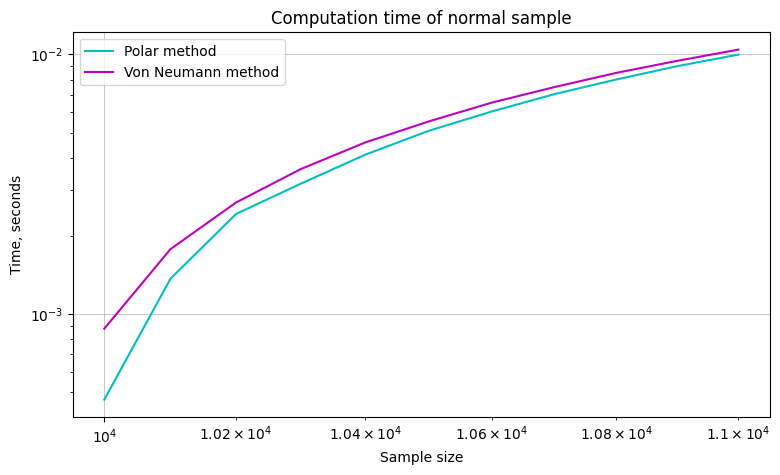

In [130]:
n_bins = 50
grid = np.arange(n_start, n_end + 1, step)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(grid, time_expo, color='c', label='Polar method')
ax.plot(grid, time_Cauchy, color='m', label='Von Neumann method')

plt.title('Computation time of normal sample')
plt.ylabel('Time, seconds')
plt.xlabel('Sample size')
plt.legend()
plt.show()

## Задание 5

### Условие

1. Пусть $X_i\sim \mathcal{N}(\mu,\sigma^2)$. Убедиться эмпирически в справедливости теоремы о законе больших чисел (ЗБЧ) и центральной предельной теоремы (ЦПТ): исследовать поведение суммы $S_n = \sum\limits_{i=1}^n X_i$ и эмпирического распределения величины
$$
\sqrt{n}\dfrac{S_n}{n} - a.
$$

2. Считая $\mu$, $\sigma$ неизвестными, построить доверительные интервалы для среднего и дисперсии по имеющейся выборке.

3. Пусть $X_i \sim K(a,b)$ - имеет распределение Коши с параметрами сдвига $a$ и масштаба $b$. Изучить эмпирически как ведут себя суммы $\frac{S_n}{n}$, объяснить результат и найти закон распределения данных сумм.

### Справедливость теоремы о ЗБЧ и ЦПТ

Сформулируем теорему о ЗБЧ в форме А.Я.Хинчина и ЦПТ.

__Теорема__ (о законе больших чисел в форме А.Я.Хинчина) \
Пусть $X_1,X_2,\dots$ - последовательность н.о.р.с.в. таких, что $\mathbb{E}|X_k|<\infty,~\mathbb{E}X_1=\mu$. \
Пусть $S_n = \sum_{k=1}^{n}X_k$. Тогда
$$
\forall\varepsilon>0\quad\lim_{n\to\infty}\mathbb{P}\left( \left|\dfrac{S_n}{n} - \mu\right| \geqslant \varepsilon \right) = 0.
$$

__Теорема__ (центральная предельная теоерма для независимых одинаково распределенных случайных величин) \
Пусть $X_1,X_2,\dots$ - последовательность н.о.р. (невырожденных) случайных величин с конечным вторым моментом. \
Пусть $S_n = \sum_{k=1}^{n}X_k$. Тогда
$$
\lim_{n\to\infty}\mathbb{P}\left( \dfrac{S_n-\mathbb{E}S_n}{\sqrt{\mathbb{D}S_n}} < x \right) = \mathrm{\Phi}(x) = \dfrac{1}{\sqrt{2\pi}} \int_{-\infty}^x e^{-\frac{x^2}{2}}dx.
$$

Доказательства приведены в [2], с.447-449




In [131]:
n_elements = 10**4
mu = 5
sigma = 1.5

In [132]:
sample_norm = mu + sigma * rand_norm_expo(n_elements)
sample_norm_sum = sample_norm.cumsum()
print(f'Normalized sum mean equals to {sample_norm_sum[-1]/n_elements:.4}.')

Normalized sum mean equals to 5.0.


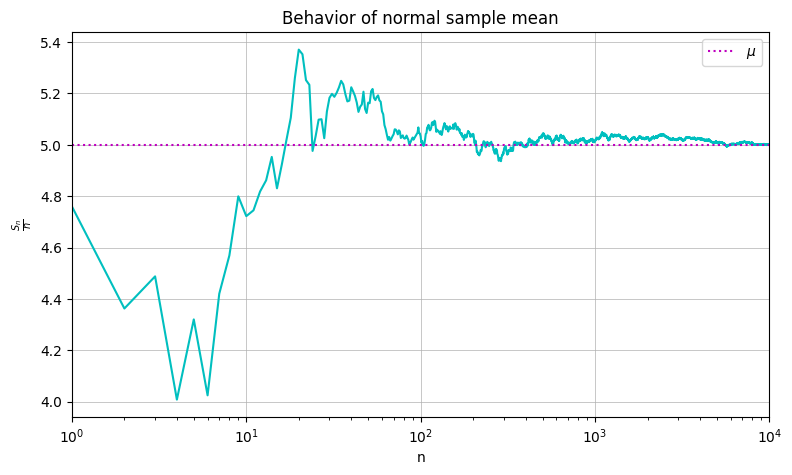

In [133]:
grid = np.arange(1, n_elements+1)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)
ax.set_xlim([1, n_elements])
ax.set_xscale('log')

ax.plot(grid, sample_norm_sum / grid, color='c')
plt.axhline(y=mu, color='m', linestyle='dotted', label='$\mu$')

ax.set_ylabel('$\\frac{S_n}{n}$')
ax.set_xlabel('n')
ax.set_title('Behavior of normal sample mean')
ax.legend()
plt.show()

Согласно ЦПТ выполняется
$$
\sqrt{n}\left( \dfrac{S_n}{n}-\mu \right) = 
\dfrac{\frac{S_n}{n} - \mu}{\frac{1}{\sqrt{n}}} \stackrel{d}{\longrightarrow} \mathrm{N}(0,\sigma^2)
$$

In [134]:
def gen_norm_sum(n_elements, loc=0.0, scale=1.0, n_points=1):
    '''
    Sum of normal random values
    n_elements - number of elements in sum
    loc - shift parameter (mu)
    scale - scale paramter (sigma)
    return vector of length n_points
    error handling in rand_norm_expo
    '''
    if not isinstance(n_points, (int, np.integer)) or n_points <= 0:
        raise ValueError('Resulting vector length must be a positive integer.')
    if not isinstance(n_elements, (int, np.integer)) or n_elements <= 0:
        raise ValueError('Count of sum elements must be a positive integer.')
    if n_points == 1:
        return loc + scale * rand_norm_expo(n_elements).sum(axis=0)
    batch_size = 5 * 10**3
    result = np.zeros(n_points)
    for i in range(0, n_points // batch_size + 1):
        if (i+1)*batch_size >= n_points:
            result[i*batch_size:] = (loc + scale * rand_norm_expo(n_elements, n_points - i*batch_size)).sum(axis=0)
        else:
            result[i*batch_size:(i+1)*batch_size] = (loc + scale * rand_norm_expo(n_elements, batch_size)).sum(axis=0)
    return result

In [135]:
n_points = 10**4
sample_norm_sum = gen_norm_sum(n_elements, mu, sigma, n_points)

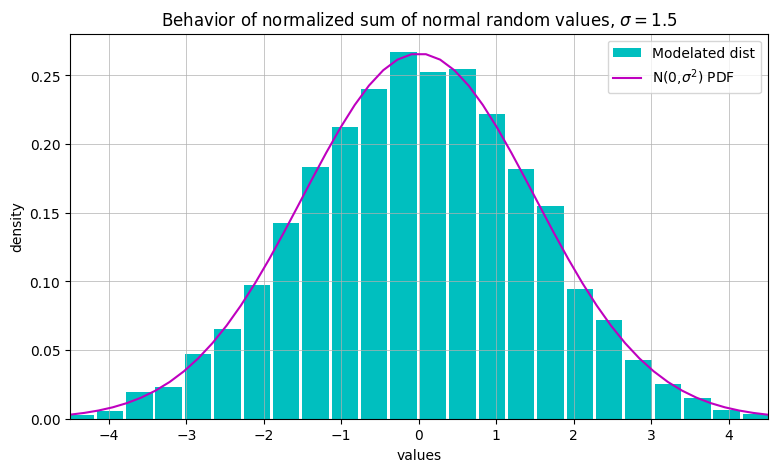

In [136]:
n_bins = 30
grid = np.linspace(-3*sigma, 3*sigma)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)
ax.set_xlim([-3*sigma, 3*sigma])

ax.hist((sample_norm_sum / n_elements- mu) * np.sqrt(n_elements),
    bins=n_bins,
    rwidth=0.9,
    density=True,
    color='c',
    label='Modelated dist'
)

ax.plot(grid, norm.pdf(grid, scale=sigma), color='m', label='N(0,$\sigma^2$) PDF')

ax.set_ylabel('density')
ax.set_xlabel('values')
ax.set_title('Behavior of normalized sum of normal random values, $\sigma=1.5$')
ax.legend()
plt.show()

### Доверительные интервалы для среднего и дисперсии

Знаем распределения следующих статистик:
$$
T = \sqrt{n}\dfrac{\overline{X} - \mu}{S} \sim t(n-1). \\
\quad D = \dfrac{\sum_{i=1}^n(\overline{X} - X_i)^2}{\sigma^2} \sim \chi^2(n-1).
$$
Здесь $\overline{X}$ - выборочное среднее, $S^2$ - несмещенная выборочная дисперсия:
$$
\overline{X} = \dfrac{\sum_{i=1}^nX_i}{n},\quad S^2 = \dfrac{\sum_{i=1}^n(\overline{X}-X_i)^2}{n-1}.
$$

Будем искать доверительные интервалы $(\gamma_1,\gamma_2)$ с уровнем значимости $\alpha$:
$$
\mathbb{P}(\gamma_1 < Y < \gamma_2) = 1-\alpha,
$$
считая $\mu,\sigma$ неизвестными. Для этого достаточно взять $\gamma_1,\gamma_2$ равными таким квантилям, что
$$
\mathbb{P}(\gamma_1 < Y < \gamma_2) = \underbrace{\mathbb{P}(Y < \gamma_2)}_{1-\frac{\alpha}{2}} - \underbrace{\mathbb{P}(Y < \gamma_1)}_{\frac{\alpha}{2}} = 1 - \alpha.
$$

Доверительный интервал для среднего $\mu$ ищем при $Y=T$.
$$
\mathbb{P}(\gamma_1 < T < \gamma_2) = \mathbb{P}\left(\gamma_1 < \sqrt{n}\dfrac{\overline{X} - \mu}{S} < \gamma_2\right) =
\mathbb{P}\left( \overline{X}-\dfrac{\gamma_2S}{\sqrt{n}} < \mu < \overline{X}-\dfrac{\gamma_1S}{\sqrt{n}} \right) = 1-\alpha.
$$

Выберем
$$
\gamma_1 = F^{-1}_{t(n-1)}\left(\frac{\alpha}{2} \right),\quad \gamma_2 = F^{-1}_{t(n-1)}\left(1-\dfrac{\alpha}{2}\right).
$$

Таким образом, $\mu\in\left(\overline{X}-\dfrac{\gamma_2S}{\sqrt{n}},\overline{X}-\dfrac{\gamma_1S}{\sqrt{n}}\right)$ с вероятностью $1-\alpha$.

Доверительный интервал для дисперсии $\sigma^2$ ищем при $Y=D$.
$$
\begin{aligned}
\mathbb{P}(\gamma_1 < D < \gamma_2) &= \mathbb{P}\left(\gamma_1 < \dfrac{\sum_{i=1}^n(\overline{X} - X_i)^2}{\sigma^2} < \gamma_2\right) = \\
&=\mathbb{P}\left( \dfrac{\sum_{i=1}^n(\overline{X} - X_i)^2}{\gamma_2} < \sigma^2 < \dfrac{\sum_{i=1}^n(\overline{X} - X_i)^2}{\gamma_1} \right) = 1-\alpha.
\end{aligned}
$$

Выберем
$$
\gamma_1 = F^{-1}_{\chi^2(n-1)}\left(\frac{\alpha}{2} \right),\quad \gamma_2 = F^{-1}_{\chi^2(n-1)}\left(1-\dfrac{\alpha}{2}\right).
$$

Таким образом, $\sigma^2\in\left(\dfrac{\sum_{i=1}^n(\overline{X} - X_i)^2}{\gamma_2}, \dfrac{\sum_{i=1}^n(\overline{X} - X_i)^2}{\gamma_1}\right)$ с вероятностью $1-\alpha$.

In [140]:
from scipy.stats import t

n_elements = 10**3
mu = 2
sigma = 3
alpha = 0.05
n_tests = 1000
test_mu_confidence = 0
gamma_1 = t.ppf(alpha / 2, df=n_elements-1)
gamma_2 = t.ppf(1 - alpha / 2, df=n_elements-1)
for i in range(n_tests):
    sample = mu + sigma * rand_norm_expo(n_elements)
    sample_mean = sample.mean()
    sample_std = sample.std()
    left = sample_mean - gamma_2 * sample_std / np.sqrt(n_elements)
    right = sample_mean - gamma_1 * sample_std / np.sqrt(n_elements)
    if mu > left and mu < right:
        test_mu_confidence += 1

print('Confidence interval contains mu in {:.4}% cases.'.format(100 * test_mu_confidence / n_tests))

Confidence interval contains mu in 94.8% cases.


In [141]:
n_elements = 10**4
gamma_1 = np.zeros(n_elements)
gamma_2 = np.zeros(n_elements)

sample = mu + sigma * rand_norm_expo(n_elements)
grid = np.arange(1, n_elements+1)
sample_sum_mean = sample.cumsum() / grid
sample_sum_std = np.zeros(n_elements)
for m in range(2, n_elements+1):
    sample_sum_std[m-1] = sample[:m].std()
    gamma_1[m-1] = t.ppf(alpha / 2, df=m-1)
    gamma_2[m-1] = t.ppf(1 - alpha / 2, df=m-1)

mu_lower_bound = sample_sum_mean - gamma_2 * sample_sum_std / np.sqrt(grid)
mu_upper_bound = sample_sum_mean - gamma_1 * sample_sum_std / np.sqrt(grid)

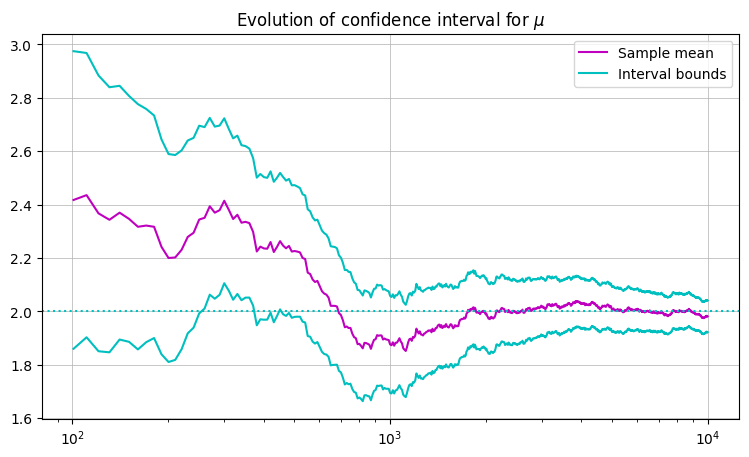

In [142]:
n_start = 100
n_end = 10**4 + 1
step = 10

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.plot(grid[n_start:n_end:step], sample_sum_mean[n_start:n_end:step], color='m', label='Sample mean')
ax.plot(grid[n_start:n_end:step], mu_lower_bound[n_start:n_end:step], color='c', label='Interval bounds')
ax.plot(grid[n_start:n_end:step], mu_upper_bound[n_start:n_end:step], color='c')
plt.axhline(mu, color='c', linestyle='dotted')

ax.set_title('Evolution of confidence interval for $\mu$')
ax.set_xscale('log')
plt.legend()
plt.show()

In [143]:
n_elements = 10**3
mu = 2
sigma = 3
var = sigma*sigma

alpha = 0.05
n_tests = 1000
test_sigma_confidence = 0
gamma_1 = chi2.ppf(alpha / 2, df=n_elements-1)
gamma_2 = chi2.ppf(1 - alpha / 2, df=n_elements-1)
for i in range(n_tests):
    sample = mu + sigma * rand_norm_expo(n_elements)
    sample_mean = sample.mean()
    sample_var = sample.var()
    left = n_elements * sample_var / gamma_2
    right = n_elements * sample_var / gamma_1
    if var > left and var < right:
        test_sigma_confidence += 1
print('Confidence interval contains sigma^2 in {:.4}% cases.'.format(100 * test_sigma_confidence / n_tests))

Confidence interval contains sigma^2 in 94.8% cases.


In [145]:
n_elements = 10**4
gamma_1 = np.zeros(n_elements)
gamma_2 = np.zeros(n_elements)

gamma_1[0] = 1
gamma_2[0] = 1

sample = mu + sigma * rand_norm_expo(n_elements)
grid = np.arange(1, n_elements+1)
sample_sum_var = np.zeros(n_elements)
for m in range(2, n_elements+1):
    sample_sum_var[m-1] = sample[:m].var()
    gamma_1[m-1] = chi2.ppf(alpha / 2, df=m-1)
    gamma_2[m-1] = chi2.ppf(1 - alpha / 2, df=m-1)

sigma_lower_bound = grid * sample_sum_var / gamma_2
sigma_upper_bound = grid * sample_sum_var / gamma_1

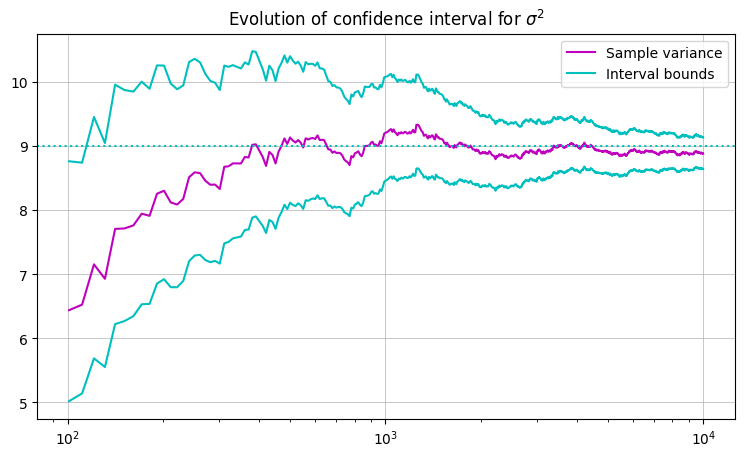

In [146]:
n_start = 100
n_end = 10**4 + 1
step = 10

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)

ax.plot(grid[n_start:n_end:step], sample_sum_var[n_start:n_end:step], color='m', label='Sample variance')
ax.plot(grid[n_start:n_end:step], sigma_lower_bound[n_start:n_end:step], color='c', label='Interval bounds')
ax.plot(grid[n_start:n_end:step], sigma_upper_bound[n_start:n_end:step], color='c')
plt.axhline(var, color='c', linestyle='dotted')

ax.set_title('Evolution of confidence interval for $\sigma^2$')
ax.set_xscale('log')
plt.legend()
plt.show()

### Распределение суммы элементов распределения Коши

Рассмотрим $X_1,X_2,\dots\sim C(a,b)$, где $a$ - параметр сдвига, $b>0$ - параметр масштаба. Как известно, плотность распределения Коши задаётся в виде
$$
\dfrac{1}{\pi b\left(1 + (\frac{x-a}{b})^2 \right)}.
$$
Характеристическая функция $\xi\sim C(0,1)$ равна
$$
\varphi_\xi(t) = \int_{-\infty}^{+\infty}e^{itx}\dfrac{dx}{\pi(1+x^2)} = e^{-|t|}.
$$
Используем её для вычисления характеристической функции $X_1$.
$$
\begin{aligned}
\varphi_{X_1}(t) &= \int_{-\infty}^{+\infty}e^{itx}\dfrac{dx}{\pi b\left(1 + (\frac{x-a}{b})^2 \right)} =
\begin{vmatrix}
\begin{array}{c}
x=yb + a \\
dx = bdy
\end{array}
\end{vmatrix} = \\
&= e^{iat}\int_{-\infty}^{+\infty} e^{itby} \dfrac{dy}{\pi(1+y^2)} = e^{iat - b|t|}.
\end{aligned}
$$

Рассмотрим $Y=\frac{S_n}{n} = \frac{\sum_{i=1}^nX_i}{n}$. Тогда
$$
\begin{aligned}
\varphi_Y(t) &= \mathbb{E}e^{itY} = \mathbb{E}\exp\left\{it \frac{\sum_{i=1}^nX_i}{n} \right\} = \left\{ н.о.р.с.в. \right\} = \\
&= \left( \mathbb{E}\exp\left\{i\frac{t}{n}X_1 \right\} \right)^n = \left( \varphi_{X_1}\left(\frac{t}{n}\right) \right)^n = e^{iat - b|t|}.
\end{aligned}
$$
Таким образом, $Y\sim C(a,b)$.

In [147]:
def gen_Cauchy_sum(n_elements, loc=0.0, scale=1.0, n_points=1):
    '''
    Sum of Cauchy distributed random values
    n_elements - number of elements in sum
    loc - shift parameter (mu)
    scale - scale paramter (sigma)
    return vector of length n_points
    error handling in rand_Cauchy
    '''
    if not isinstance(n_points, (int, np.integer)) or n_points <= 0:
        raise ValueError('Resulting vector length must be a positive integer.')
    if not isinstance(n_elements, (int, np.integer)) or n_elements <= 0:
        raise ValueError('Count of sum elements must be a positive integer.')
    if n_points == 1:
        return loc + scale * rand_norm_expo(n_elements).sum(axis=0)
    batch_size = 5 * 10**3
    result = np.zeros(n_points)
    for i in range(0, n_points // batch_size + 1):
        if (i+1)*batch_size >= n_points:
            result[i*batch_size:] = rand_Cauchy(loc, scale, n_elements, n_points - i*batch_size).sum(axis=0)
        else:
            result[i*batch_size:(i+1)*batch_size] = rand_Cauchy(loc, scale, n_elements, batch_size).sum(axis=0)
    return result

In [154]:
n_elements = 10**3
n_points = 10**5
loc = 3
scale = 5

sample_Cauchy_sum = gen_Cauchy_sum(n_elements, loc, scale, n_points) / n_elements

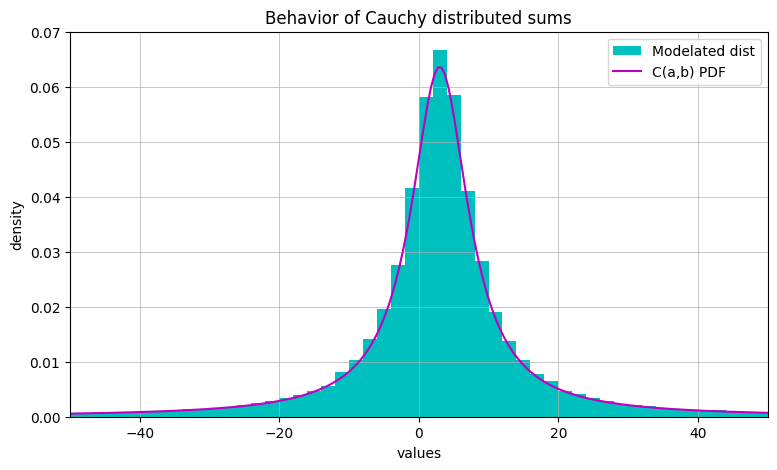

In [161]:
n_bins = 50
step = 50
grid_size = 200

sample_mean = sample_Cauchy_sum.mean()
grid = np.linspace(-step, step, grid_size)

fig = plt.figure(figsize=(9, 5))
ax = plt.axes()
ax.grid()
ax.grid('minor', linewidth=0.5)
ax.set_xlim([-step, step])

ax.hist(sample_Cauchy_sum,
    bins=n_bins,
    range=(-step, step),
    density=True,
    color='c',
    label='Modelated dist'
)
ax.plot(grid, scale / (np.pi * (scale**2 + (grid - loc)**2)),
    color='m',
    label='C(a,b) PDF'
)

ax.set_ylabel('density')
ax.set_xlabel('values')
ax.set_title('Behavior of Cauchy distributed sums')
plt.legend()
plt.show()

## Задание 6

### Условие

1. Вычислить следующий интеграл:
$$
I = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}\cdots\int_{-\infty}^{\infty}
\dfrac{e^{-(x_1^2+x_2^2+\dots+x_{10}^2 + \frac{1}{2^7\cdot x_1^2\cdots x_{10}^2})}}{x_1^2\cdot\dots\cdot x_{10}^2}
dx_1dx_2\dots dx_{10}
$$

- Методом Монте-Карло
- Методом квадратур, сводя задачу к вычислению собственного интеграла Римана.

2. Оценить точность вычислений для каждого из двух случаев.

### Вычисление интеграла

Можно заметить, что интеграл существует, и он представим в виде
$$
\begin{aligned}
I &= \pi^5\int_{-\infty}^{\infty}\int_{-\infty}^{\infty}\cdots\int_{-\infty}^{\infty}
\underbrace{\dfrac{1}{\sqrt{\pi}^{10}}\exp\left\{ -\sum_{i=1}^{10}x_i^2 \right\}}_{p_{\xi}(x_1,x_2,\dots,x_{10})} \cdot 
\underbrace{\dfrac{\exp\left\{- \frac{1}{2^7\cdot\prod_{i=1}^{10}x_i^2} \right\}}{\prod_{i=1}^{10}x_i^2}}_{f(x_1,x_2,\dots,x_{10})}
dx_1dx_2\dots dx_{10} = \\
&= \pi^5\int_{-\infty}^{\infty}\int_{-\infty}^{\infty}\cdots\int_{-\infty}^{\infty}f(x_1,x_2,\dots,x_{10})p_{\xi}(x_1,x_2,\dots,x_{10})
dx_1dx_2\dots dx_{10},
\end{aligned}
$$
что равняется $\mathbb{E}[f(\xi)]$, где $\xi$ - случайный вектор, компонентами которого являются независимые нормально распределенные случайные величины с параметрами $\mu=0, \sigma^2=\frac{1}{2}$.

Независимость следует из того, что совместная плотность представима в виде произведения плотностей отдельных компонент:
$$
p_{\xi}(x_1,x_2,\dots,x_{10}) = p_{\xi_1}(x_1)p_{\xi_2}(x_2)\cdots p_{\xi_{10}}(x_{10}),
$$
где $\xi=(\xi_1,\xi_2,\dots,\xi_{10}),~ \xi_i\sim\mathrm{N}(0,\frac{1}{2}),~ i=\overline{1,10}$.

Рассмотрим $\eta_i=f(\xi),i=\overline{1,n}$ - н.о.р.с.в. \
Согласно теореме о законе больших чисел
$$
\dfrac{\eta_1 + \eta_2 + \dots + \eta_n}{n} \stackrel{\mathbb{P}}{\longrightarrow} \mathbb{E}\eta_1,~ n\to\infty.
$$

In [162]:
def calculate_integral_monte_carlo(n_samples):
    '''
    Calculate integral using Monte Carlo method
    n_samples is a positive integer number, determines number of samples modelated
    '''
    if not isinstance(n_samples, (int, np.integer)) or n_samples <= 0:
        raise ValueError('Number of samples must be a positive integer.')
    sample_norm = np.sqrt(0.5) * rand_norm_expo(10, n_samples)
    x_2_prod_inv = 1 / np.power(sample_norm, 2).prod(axis=0)
    exponent = np.exp(- x_2_prod_inv / 2**7)
    my_const = np.pi ** 5
    return (my_const * exponent * x_2_prod_inv).mean()

In [167]:
n_samples = 10**7
integral_monte_carlo = calculate_integral_monte_carlo(n_samples)
print(f'Integral equals to {integral_monte_carlo:.4}.')

Integral equals to 124.6.


Альтернативно воспользуемся методом прямоугольников. Для этого рассмторим замену $x_i = \operatorname{tg}(\frac{\pi}{2}\varphi_i),~i=\overline{1,10}$. Определитель якобиана равен
$$
|J| = \left( \dfrac{\pi}{2} \right)^{10} \left(\prod^{10}_{i=1}\cos\left(\frac{\pi}{2}\phi_i\right)\right)^{-1}.
$$
Интеграл равен
$$
\begin{aligned}
I &= \left( \dfrac{\pi}{2} \right)^{10}\int_{-1}^1\int_{-1}^{1}\cdots\int_{-1}^1 \theta(\phi_1,\phi_2,\dots,\phi_{10})d\phi_1d\phi_2\dots d\phi_{10}, \\
\theta(\phi_1,\phi_2,\dots,\phi_{10}) &= \dfrac{1}{\prod^{10}_{i=1}\sin^2\left(\frac{\pi}{2}\phi_i\right)}
\exp\left\{ -\left( \sum_{i=1}^{10}\operatorname{tg}^2\left(\frac{\pi}{2}\varphi_i\right) + \dfrac{1}{2^7}\prod^{10}_{i=1}\operatorname{сtg}^2\left(\frac{\pi}{2}\varphi_i\right) \right) \right\}.
\end{aligned}
$$

Подинтегральная функция $\theta(\overline\varphi)$ обладает следующими свойствами.
- $\theta(\overline\varphi)$ четна по каждому аргументу.
- $\theta(\overline\varphi)$ инвариантна относительно перестановки аргументов $\phi_i\mapsto\phi_j,i\neq j$.

Первое свойство позволяет свести пределы интегрирования к $[0,1]$, т.е.
$$
\begin{aligned}
I &= \pi^{10} \int_{0}^1\int_{0}^{1}\cdots\int_{0}^1 \theta(\phi_1,\phi_2,\dots,\phi_{10})d\phi_1d\phi_2\dots d\phi_{10}.
\end{aligned}
$$
Введём равномерную сетку на $(0,1)^{10}$.
$$
T = \{ (t^1_{i_1}, t^2_{i_2}, \dots, t^{10}_{i_{10}})~|~t^k_{i_k} = \dfrac{i_k + \frac{1}{2}}{N+1},~ i_k=\overline{1,N},~ k=\overline{1,10} \}.
$$
Тогда
$$
I \approx \left( \dfrac{\pi}{N} \right)^{10} \sum_{i=1}^{N}\dots\sum_{i_{10}=1}^{N} \theta(t^1_{i_1}, t^2_{i_2}, \dots, t^{10}_{i_{10}}) = 
\left( \dfrac{\pi}{N} \right)^{10} \sum_{i=1}^{N}\dots\sum_{i_{10}=1}^{N}
\theta\left(\dfrac{i_1 + \frac{1}{2}}{N+1}, \dfrac{i_2 + \frac{1}{2}}{N+1}, \dots, \dfrac{i_{10} + \frac{1}{2}}{N+1} \right).
$$
В силу инвариантности под знаками суммирования возникают равные значения для перестановок одного и того же набора индексов. \
Для каждого набора различных индексов таких перестановок всего $10!$. \
Для набора индексов, где встречаются равные значения, таких перестановок всего существует
$$
\frac{10!}{m_1!m_2!\cdots m_{N}!},
$$
где $m_k!$ - число индексов в наборе $(i_1,i_2,\dots,i_{10})$, равных $k$.

Таким образом,
$$
I \approx \left( \dfrac{\pi}{N} \right)^{10} \sum_{1\leqslant i_0\leqslant i_1\leqslant\dots \leqslant i_{10}\leqslant N}
\frac{10!}{m_1!m_2!\cdots m_N!}\cdot
\theta\left(\dfrac{i_1 + \frac{1}{2}}{N+1}, \dfrac{i_2 + \frac{1}{2}}{N+1}, \dots, \dfrac{i_{10} + \frac{1}{2}}{N+1} \right).
$$

In [168]:
def calculate_integral_quad(grid_size):
    '''
    Calculate integral using rectangular method
    grid_size is a positive integer number, determines size of uniform grid
    '''
    def my_integrand(x):
        tg_2 = np.power(np.tan(np.pi * x / 2), 2)
        tg_2_sum = tg_2.sum()
        tg_2_prod = tg_2.prod()
        sin_2_prod = np.power(np.sin(np.pi * x / 2), 2).prod()
        return np.exp(- tg_2_sum - 1 / (2**7 * tg_2_prod)) / sin_2_prod
    def my_coefficient(indexes):
        _, counts = np.unique(indexes, return_counts=True)
        divider = 1
        for num in counts:
            divider *= factorial(num)
        return factorial(10) / divider

    if not isinstance(grid_size, (int, np.integer)) or grid_size <= 0:
        raise ValueError('Grid size must be a positive integer number.')
    grid = np.linspace(0.5/(grid_size+1), 1 - 0.5/(grid_size+1), num=grid_size)
    combinations = list(combinations_with_replacement(np.arange(0, grid_size), 10))
    result_sum = 0
    for combination in combinations:
        theta = my_integrand(np.array([grid[i] for i in combination]))
        result_sum += my_coefficient(combination) * theta
    return (np.pi / grid_size)**10 * result_sum

### Оценка точности вычисления

In [174]:
step = 10**4
N_start = 10**3
N_end = N_start + 10**6
n_tests = (N_end - N_start) // step + 1

In [ ]:
test_monte_carlo = np.zeros(n_tests)
for i in range(n_tests):
    N_curr = N_start + i * step
    result = calculate_integral_monte_carlo(N_curr)
    test_monte_carlo[i] = result

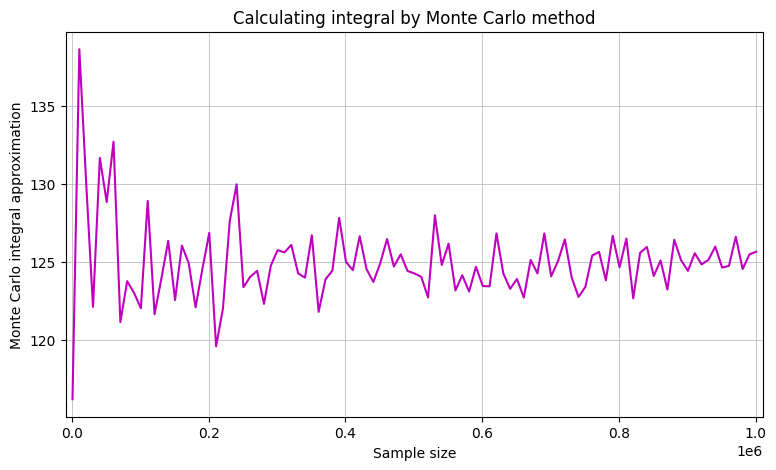

In [176]:
grid = np.linspace(N_start, N_end, num=n_tests, endpoint=True)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)
ax.set_xlim([N_start-step, N_end+step])
ax.plot(grid, test_monte_carlo, color='m')

plt.title('Calculating integral by Monte Carlo method')
plt.xlabel('Sample size')
plt.ylabel('Monte Carlo integral approximation')
plt.show()

In [171]:
step = 1
N_start = 6
N_end = 20
n_tests = (N_end - N_start) // step + 1
test_params = np.arange(N_start, N_end + 1, step)

test_quad = np.zeros(n_tests)
for i in range(n_tests):
    test_quad[i] = calculate_integral_quad(test_params[i])

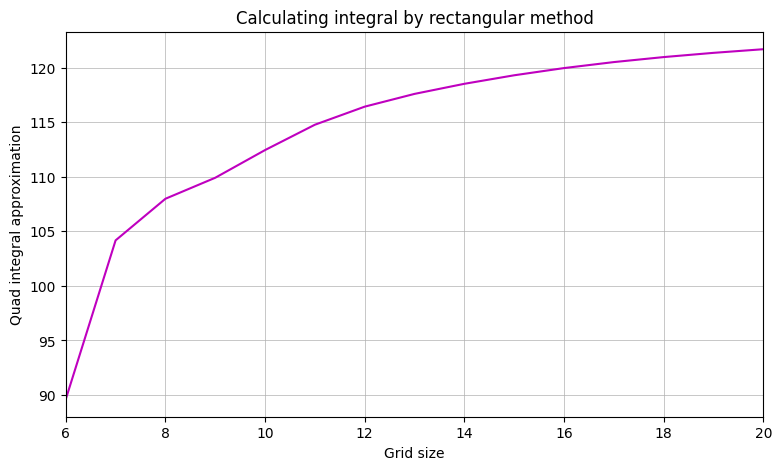

In [172]:
grid = np.linspace(N_start, N_end, num=n_tests, endpoint=True)

fig = plt.figure(figsize=(9,5))
ax = plt.axes()
ax.grid('minor', linewidth=0.5)
ax.set_xlim([N_start, N_end])

ax.plot(grid, test_quad, color='m')

plt.title('Calculating integral by rectangular method')
plt.xlabel('Grid size')
plt.ylabel('Quad integral approximation')
plt.show()

In [173]:
%store test_quad

Stored 'test_quad' (ndarray)


c:\Users\arinenn\Desktop\Practicum7\.venv\lib\site-packages\IPython\extensions\storemagic.py:229: UserWarning: using autorestore/test_quad requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj


## Список литературы

[1]. Смирнов С.Н. Лекции по стохастическому анализу, 2024.

[2]. Ширяев А.Н. Вероятность, Кн. 1 - М.:МЦНМО, 2021. 

[3]. [L. Devroye, Non-uniform random variate generation, Springer-Verlag, New York, 1986.](https://www.cs.fsu.edu/~mascagni/Devroye.pdf)

[4]. Кропачева Н.Ю., Тихомиров А.С. Моделирование случайных величин: Метод. указания - Великий Новогород, 2004.

[5]. Некрутин В.В. Моделирование распределений, 2014.